# Final Project: Predicting Banking Customer Churn
By Wei Yu Wang
DTSA 5511, April 2024

Kaggle Competition Link
https://www.kaggle.com/competitions/coder-52295-season-finale

In [333]:
# importing modules

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from tensorflow.keras.models import Sequential
from tensorflow.keras import Input
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.metrics import accuracy_score, classification_report
from sklearn.utils.class_weight import compute_class_weight
import tensorflow as tf
from tensorflow.keras.layers import InputLayer, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import RandomUniform

from pytorch_tabnet.tab_model import TabNetClassifier
import torch

import optuna

# Define the initializer with a seed
initializer = RandomUniform(seed=42)


## Introduction: 

In this project, I am going to work on a Kaggle Competition [Season Finale: Predict whether a customer continues with their account or closes it (e.g., churns)](https://www.kaggle.com/competitions/coder-52295-season-finale). I would like to further my skills in deep learning applications to tabular data and this seemed like the perfect project.

My blueprint is:
1. Data Gathering
2. EDA, cleaning Data, and Transformations
3. Build Baseline Random Forest Supervised Machine Learning Method for Comparison
4. Build a Simple CNN
5. Replicate a CNN for unbalanced classes
6. Build and Tune TabNet
7. Build, Explore and Tune DeepTable Models
8. Discussion and Conclusion 

## Data Gathering, Method of Data Collection and Provenance of Data

The source of the data is from a Kaggle Competition Coder 52295 - [Season Finale: Predict whether a customer continues with their account or closes it (e.g., churns)](https://www.kaggle.com/competitions/coder-52295-season-finale). The method of data collection is that it is generated from another [dataset](https://www.kaggle.com/datasets/shubhammeshram579/bank-customer-churn-prediction) from a deep learning model keeping a close but not exact feature distribution to the original. 

### Provenance: 
Sources:
The Bank Customer Churn dataset can be found on Kaggle (https://www.kaggle.com/adammaus/predicting-churn-for-bank-customers).
Collection Methodology

the UCI Machine Learning Repository (https://archive.ics.uci.edu/ml/datasets/bank+customer+churn+prediction).

Both datasets are currently inaccessible. Being a banking information dataset, there have likely been privacy concerns.

## Identifying the Deep Learning Problem

This is a Kaggle completition so focus will be on model building and analysis. At the time of writing, I am the only person that have submitted anything to the public leaderboard. Nothing is in the sections of discussion, models, or code. 

I will be extending my knowledge on neural network by first setting up a convolutional neural network (CNN) and then trying newer deep learning methods such as TabNet and architectures in DeepNets. The goal of this project is to find the most optimal tabular binary classification method. 

# Exploratory Data Analysis

The EDA procedure for this project will be to first identify the features of the dataset, identifying and analyzing correlations between different features, determining if any data needs to be transformed and then performing transformations, data cleaning, and identifying if specific factors should be more important than others in the analysis. 

## Loading the Dataset

In [35]:
train_df = pd.read_csv('train.csv')
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 165034 entries, 0 to 165033
Data columns (total 14 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   id               165034 non-null  int64  
 1   CustomerId       165034 non-null  int64  
 2   Surname          165034 non-null  object 
 3   CreditScore      165034 non-null  int64  
 4   Geography        165034 non-null  object 
 5   Gender           165034 non-null  object 
 6   Age              165034 non-null  float64
 7   Tenure           165034 non-null  int64  
 8   Balance          165034 non-null  float64
 9   NumOfProducts    165034 non-null  int64  
 10  HasCrCard        165034 non-null  float64
 11  IsActiveMember   165034 non-null  float64
 12  EstimatedSalary  165034 non-null  float64
 13  Exited           165034 non-null  int64  
dtypes: float64(5), int64(6), object(3)
memory usage: 17.6+ MB


First, lets see if the Exited Class is balanced. It looks like only 21.2% of the customers have exited so the majority of customers have stayed. Because the competition is based on accuracy, our models have to perform better than 78.8% because that is the accuracy if a model predicted every customer as stayed. 

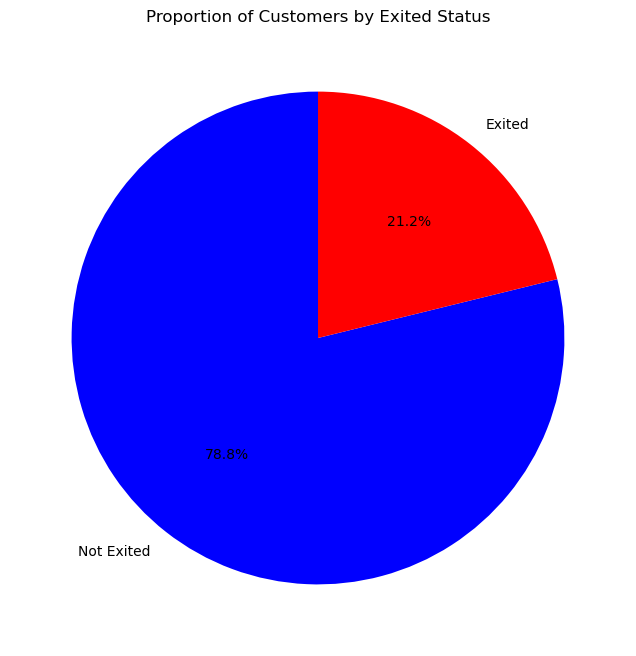

In [48]:
# Calculate counts for each category
exited_counts = train_df['Exited'].value_counts()

# Create the pie chart
plt.figure(figsize=(8, 8))  # Set the figure size for better visibility
plt.pie(exited_counts, labels=['Not Exited', 'Exited'], autopct='%1.1f%%', startangle=90, colors=['blue', 'red'])

# Adding a title
plt.title('Proportion of Customers by Exited Status')

# Display the pie chart
plt.show()

In [36]:
train_df.head()

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,0,15674932,Okwudilichukwu,668,France,Male,33.0,3,0.00,2,1.0,0.0,181449.97,0
1,1,15749177,Okwudiliolisa,627,France,Male,33.0,1,0.00,2,1.0,1.0,49503.50,0
2,2,15694510,Hsueh,678,France,Male,40.0,10,0.00,2,1.0,0.0,184866.69,0
3,3,15741417,Kao,581,France,Male,34.0,2,148882.54,1,1.0,1.0,84560.88,0
4,4,15766172,Chiemenam,716,Spain,Male,33.0,5,0.00,2,1.0,1.0,15068.83,0


From the header, it can be seen that CustomerId and Surname are included which will only add noise to any models created These should be removed.

In [37]:
# Removing Identifying Columns
train_df = train_df.drop(['id', 'CustomerId', 'Surname'], axis=1)

There are a combination of integers, floats and texts. Integers should only represent categorical columns and text should all be converted into integers using an encoding method such as One-hot encoding. This will be done at the end of the EDA.

CreditScore, Tenure, NumOfProducts should be converted into floats. 

In [38]:
train_df['CreditScore'] = train_df['CreditScore'].astype(float)
train_df['Tenure'] = train_df['Tenure'].astype(float)
train_df['NumOfProducts'] = train_df['NumOfProducts'].astype(float)

For text features, I will identify the unique values

In [39]:
train_df['Geography'].unique()

array(['France', 'Spain', 'Germany'], dtype=object)

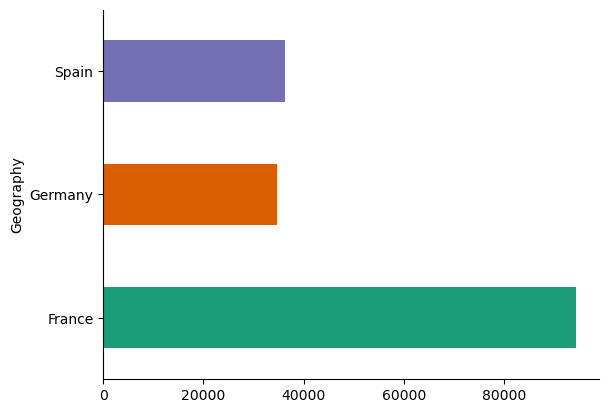

In [40]:
# Total Rows
train_df.groupby('Geography').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

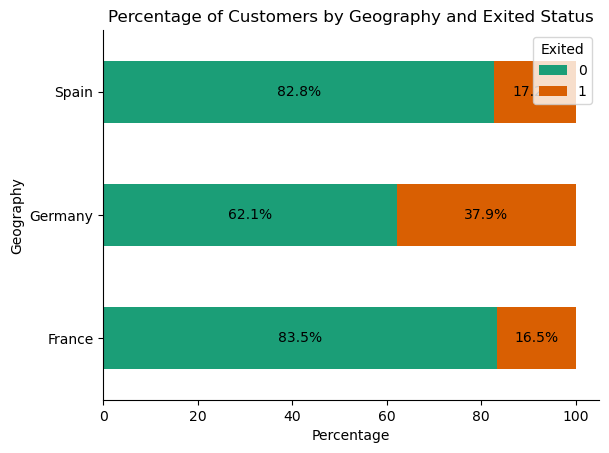

In [41]:
# Percentage of Customers by Geography and Exited Status

# Calculate counts per category split by 'Exited'
count_data = train_df.groupby(['Geography', 'Exited']).size().unstack(fill_value=0)

# Convert counts to percentages
percentage_data = count_data.div(count_data.sum(axis=1), axis=0) * 100

# Create the bar plot
ax = percentage_data.plot(kind='barh', stacked=True, color=sns.color_palette('Dark2'))

# Adding titles and labels
plt.title('Percentage of Customers by Geography and Exited Status')
plt.xlabel('Percentage')
plt.ylabel('Geography')

# Hide top and right spines
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Annotate bars with percentage values
for bars in ax.containers:
    ax.bar_label(bars, fmt='%.1f%%', label_type='center')

# Show the plot
plt.show()


I will encode from the least likely to exit to the most likely exit (Frace = 1, Spain = 2, Germany = 3). The classes are unbalanced though with France having the most number of people represented in the dataset.

In [42]:
# Replace 'France' with 1.0, 'Spain' with 2.0, 'Germany' with 3.0
mapping = {'France': 1.0, 'Spain': 2.0, 'Germany': 3.0}
train_df['Geography'] = train_df['Geography'].replace(mapping)

I will also check how many genders are in the dataset

In [43]:
train_df['Gender'].unique()

array(['Male', 'Female'], dtype=object)

There is only 2 so they can be binary classified into 0 and 1.

In [44]:
gender = {'Male': 1.0, 'Female': 0.0}
train_df['Gender'] = train_df['Gender'].replace(gender)

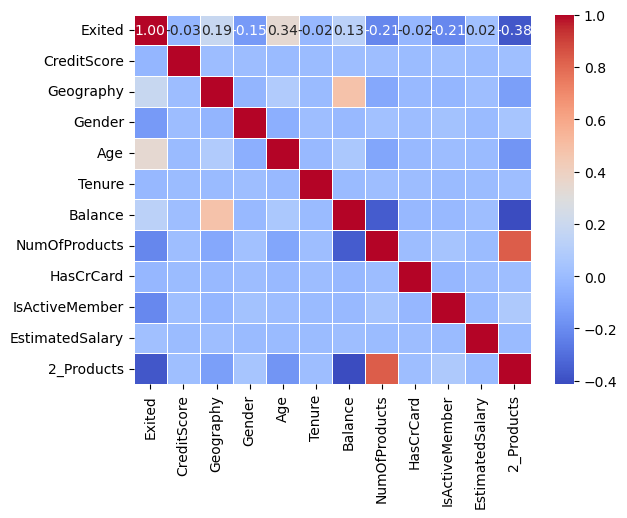

In [61]:
# Correlation Matrix
# Specify the column to move to the first position
column_to_move = 'Exited'

# Create a list of columns with the desired column at the front
new_columns = [column_to_move] + [col for col in train_df.columns if col != column_to_move]

# Reorder the columns
train_df = train_df[new_columns]
# Compute the correlation matrix
corr_matrix = train_df.corr()

# Optional: Visualize the correlation matrix using seaborn
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.show()

From the heatmap, it can be seen that customers that have exited most correlate with Age and is somewhat correlated with Geography, Balance, Number of Products, and if they are an active member.

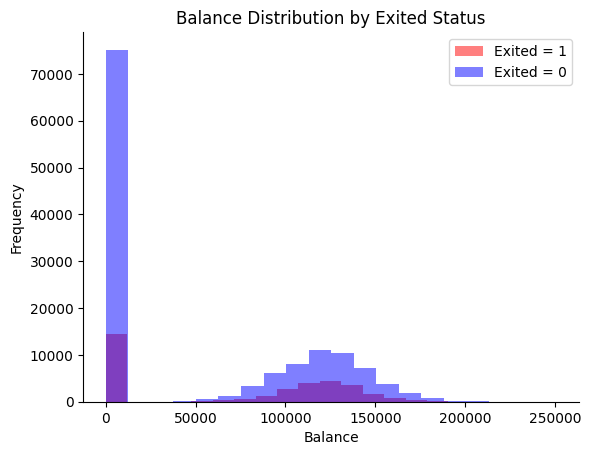

In [8]:
# Filter data based on 'Exited' status
exited_df = train_df[train_df['Exited'] == 1]
not_exited_df = train_df[train_df['Exited'] == 0]

# Create histogram for customers who exited
plt.hist(exited_df['Balance'], bins=20, alpha=0.5, label='Exited = 1', color='red')

# Create histogram for customers who did not exit
plt.hist(not_exited_df['Balance'], bins=20, alpha=0.5, label='Exited = 0', color='blue')

# Adding titles and labels
plt.title('Balance Distribution by Exited Status')
plt.xlabel('Balance')
plt.ylabel('Frequency')

# Hide top and right spines
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Add a legend to the plot
plt.legend()

# Show the plot
plt.show()

It looks like the Balance is either below 50000 or above 50000. Let's explore how correlation is affected if the dataset becomes more correlated if any balance greater than 50000 is 1 and less than is 0. 

In [49]:
train_df['High_Balance'] = np.where(train_df['Balance'] > 50000, 1.0, 0)

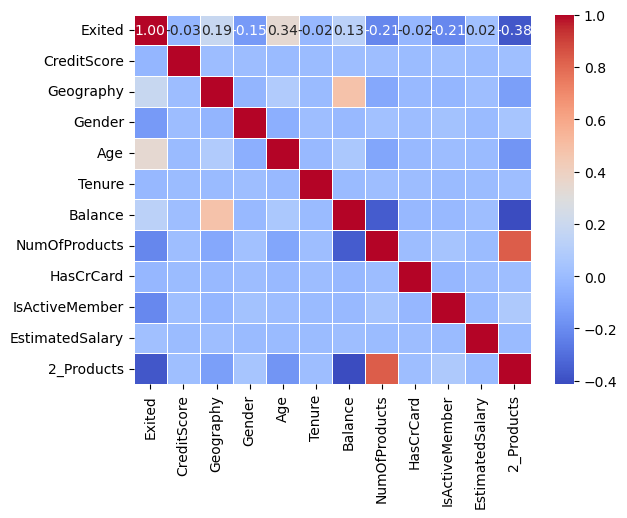

In [59]:
# Correlation Matrix
# Specify the column to move to the first position
column_to_move = 'Exited'

# Create a list of columns with the desired column at the front
new_columns = [column_to_move] + [col for col in train_df.columns if col != column_to_move]

# Reorder the columns
train_df = train_df[new_columns]
# Compute the correlation matrix
corr_matrix = train_df.corr()

# Optional: Visualize the correlation matrix using seaborn
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.show()

It does not look like correlation has changed. From the bar chart, it can be seen that people with 0 balance are less likely to leave. This new column will not be kept

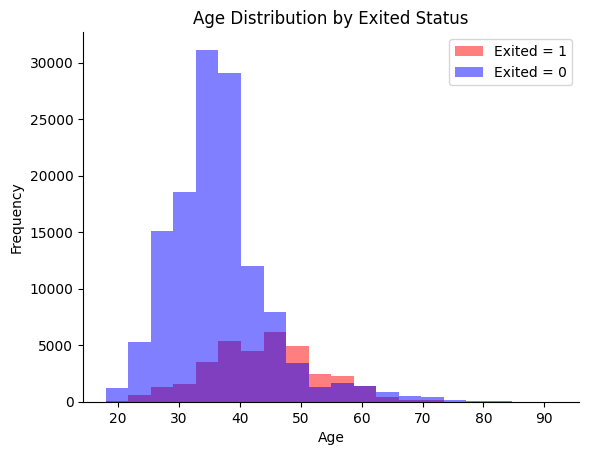

In [12]:
# Filter data based on 'Exited' status
exited_df = train_df[train_df['Exited'] == 1]
not_exited_df = train_df[train_df['Exited'] == 0]

# Create histogram for customers who exited
plt.hist(exited_df['Age'], bins=20, alpha=0.5, label='Exited = 1', color='red')

# Create histogram for customers who did not exit
plt.hist(not_exited_df['Age'], bins=20, alpha=0.5, label='Exited = 0', color='blue')

# Adding titles and labels
plt.title('Age Distribution by Exited Status')
plt.xlabel('Age')
plt.ylabel('Frequency')

# Hide top and right spines
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Add a legend to the plot
plt.legend()

# Show the plot
plt.show()


From the chart, it looks like customers that have exited tend to be older with a mean at around 40 and 50 compared to 30 and 40.

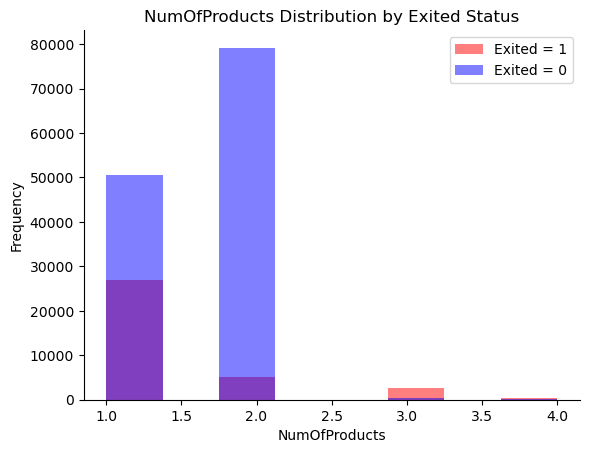

In [54]:
import matplotlib.pyplot as plt

# Filter data based on 'Exited' status
exited_df = train_df[train_df['Exited'] == 1]
not_exited_df = train_df[train_df['Exited'] == 0]

# Create histogram for customers who exited
plt.hist(exited_df['NumOfProducts'], bins=8, alpha=0.5, label='Exited = 1', color='red')

# Create histogram for customers who did not exit
plt.hist(not_exited_df['NumOfProducts'], bins=8, alpha = 0.5, label='Exited = 0', color='blue')

# Adding titles and labels
plt.title('NumOfProducts Distribution by Exited Status')
plt.xlabel('NumOfProducts')
plt.ylabel('Frequency')

# Hide top and right spines
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Add a legend to the plot
plt.legend()

# Show the plot
plt.show()


It seems like customers with 2 products are unlikely to leave. Customers with 1, 3, or 4 are more likely to leave.
Let's explore modifying this column to 2 products or not for binary classification.

In [55]:
train_df['2_Products'] = np.where(train_df['NumOfProducts'] == 2, 1.0, 0)

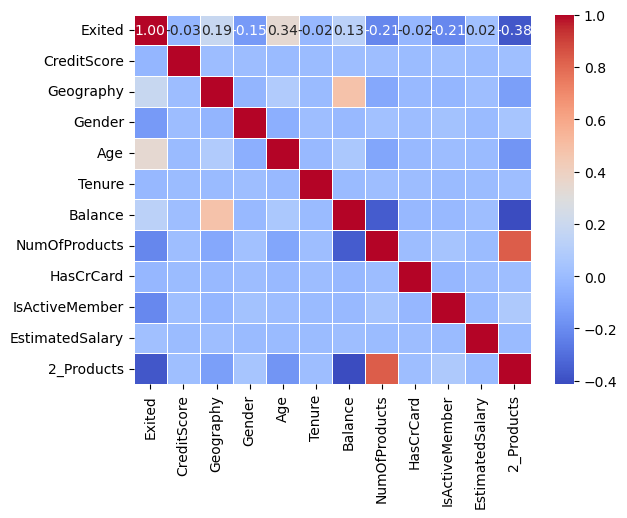

In [58]:
# Compute the correlation matrix
corr_matrix = train_df.corr()

# Optional: Visualize the correlation matrix using seaborn
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.show()

This has significantly increased the degree of correlation from -0.21 to -0.38. 
To remove noise, only features with a correlation score above 0.1 will be kept. The NumOfProducts column will be replaced with the binary classification results if there is 2 products or not. 

In [120]:
# Creating a datapreprocessing function that takes the link to the csv and outputs a dataframe

def preprocessing(csv):
    df = pd.read_csv(csv)
    df['NumOfProducts'] = df['NumOfProducts'].astype(float)
    
    mapping = {'France': 1.0, 'Spain': 2.0, 'Germany': 3.0}
    df['Geography'] = df['Geography'].replace(mapping)
    
    gender = {'Male': 1.0, 'Female': 0.0}
    df['Gender'] = df['Gender'].replace(gender)
    
    df['2_Products'] = np.where(df['NumOfProducts'] == 2, 1.0, 0)
    
    df = df.drop(['id', 'CustomerId', 'Surname'], axis=1)
    return df

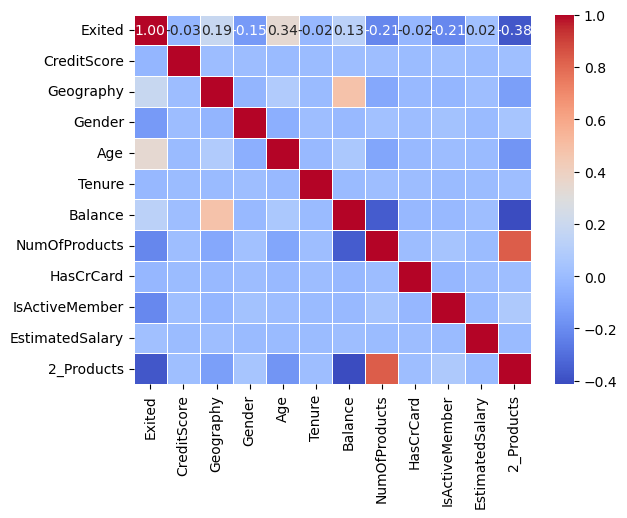

In [121]:
dtf = preprocessing('train.csv')
# Correlation Matrix
# Specify the column to move to the first position
column_to_move = 'Exited'

# Create a list of columns with the desired column at the front
new_columns = [column_to_move] + [col for col in train_df.columns if col != column_to_move]

# Reorder the columns
dtf = dtf[new_columns]
# Compute the correlation matrix
corr_matrix = dtf.corr()

# Optional: Visualize the correlation matrix using seaborn
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.show()

From my EDA, I was able to determine which features to keep for further analysis to develop a function for data preprocessing. This was done by identifying the features of the dataset, linear correlations between Exited and other features, data transformation such as adding a new feature on if there is 2 products or not, and normalizing using a min-max scalar (many features are binary classifications). There does not appear to be missing data. Deep learning allows for all features to be kept for the algorithm to identify potential non-linear relationships. 

# Model Building

From my EDA, I know that I need an accuracy of above 78.8% to be better than just labelling every customer as 0 for churning. 

Let's see if supervised machine learning returns a better result than 78.8%

### Random Forest Benchmark

In [123]:
# Baseline Random Forest

random_forest_df = preprocessing('train.csv')

# Standard Scaler
scaler = MinMaxScaler()
random_forest_df = pd.DataFrame(scaler.fit_transform(random_forest_df), columns=random_forest_df.columns)

# Splitting the dataset into training and testing sets
X = random_forest_df.drop('Exited', axis=1)
y = random_forest_df['Exited']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Creating the Random Forest model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Making predictions
y_pred = model.predict(X_test)

# Evaluating the model
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy:', accuracy)
print('Classification Report:\n', classification_report(y_test, y_pred))

Accuracy: 0.8580301148241282
Classification Report:
               precision    recall  f1-score   support

         0.0       0.89      0.94      0.91     26052
         1.0       0.71      0.54      0.62      6955

    accuracy                           0.86     33007
   macro avg       0.80      0.74      0.76     33007
weighted avg       0.85      0.86      0.85     33007



An unoptimized Random Forest is able to achieve 85.8% validation accuracy.
Now lets see if a baseline Convolutional Neural Network can improve accuracy. 

### CNN Benchmark

In [207]:
# baseline CNN

cnn_df = preprocessing('train.csv')

# Standard Scaler
scaler = MinMaxScaler()
cnn_df = pd.DataFrame(scaler.fit_transform(cnn_df), columns=cnn_df.columns)

# Define categorical and numerical features
categorical_features = ['Gender','HasCrCard', 'IsActiveMember']
numerical_features = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 
                      'EstimatedSalary', 'Geography', '2_Products']

# Create transformers for numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(), categorical_features)])

# Prepare target variable
y = cnn_df['Exited'].values

# Prepare input features
X = cnn_df.drop('Exited', axis=1)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Apply transformations
X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)

In [208]:
# Determine the input shape from the data
input_shape = [X_train.shape[1]]

# Build the model
model = Sequential([
    Input(shape=input_shape),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [209]:
# Train the model
history = model.fit(X_train, y_train, epochs=5, batch_size=32, validation_split=0.2)

Epoch 1/5
3301/3301 [==============================] - 5s 1ms/step - loss: 0.3340 - accuracy: 0.8590 - val_loss: 0.3242 - val_accuracy: 0.8650
Epoch 2/5
3301/3301 [==============================] - 5s 1ms/step - loss: 0.3260 - accuracy: 0.8629 - val_loss: 0.3237 - val_accuracy: 0.8644
Epoch 3/5
3301/3301 [==============================] - 5s 1ms/step - loss: 0.3247 - accuracy: 0.8632 - val_loss: 0.3256 - val_accuracy: 0.8641
Epoch 4/5
3301/3301 [==============================] - 5s 1ms/step - loss: 0.3236 - accuracy: 0.8643 - val_loss: 0.3255 - val_accuracy: 0.8637
Epoch 5/5
3301/3301 [==============================] - 5s 1ms/step - loss: 0.3230 - accuracy: 0.8640 - val_loss: 0.3235 - val_accuracy: 0.8647


In [210]:
# Classification Report
y_prob = model.predict(X_test)

# Convert probabilities to binary labels
y_pred = (y_prob > 0.5).astype('int32')

# Now generate the classification report
print(classification_report(y_test, y_pred))

1032/1032 [==============================] - 1s 842us/step
              precision    recall  f1-score   support

         0.0       0.89      0.94      0.92     26052
         1.0       0.73      0.57      0.64      6955

    accuracy                           0.86     33007
   macro avg       0.81      0.76      0.78     33007
weighted avg       0.86      0.86      0.86     33007



This performed better than the random forest particularily in identifying customers that exit by improving precision from 0.71 to 0.73 while maintaining precision on customers that do not exit.

In [194]:
# Baseline CNN for Kaggel

test_cnn_df = preprocessing('test.csv')
test_cnn_df = preprocessor.transform(test_cnn_df)

# Classification Report
y_prob = model.predict(test_cnn_df)

3439/3439 [==============================] - 3s 847us/step


In [195]:
# Convert probabilities to binary labels

y_prob = (y_prob > 0.5).astype('int')
y_prob = y_prob.flatten()
y_prob = y_prob.tolist()

In [197]:
output_cnn_df = pd.read_csv('test.csv')
output_cnn_df['Exited'] = y_prob
# output_cnn_df.to_csv('cnn_benchmark.csv', index = False)

Instead of running a hyperparameter tuning method, I am going to attempt to recreate a neural network for imbalanced classification. 

### Imbalanced Classification Neural Network Architecture

In [211]:
# Model Based on Imbalanced Classification: https://huggingface.co/keras-io/imbalanced_classification

# Building the neural network
imbalanced_model = Sequential([
    Input(shape=input_shape),
    Dense(128, activation='relu', name='dense_4'),
    Dense(64, activation='relu', name='dense_5'),
    Dropout(0.5, name='dropout_2'),
    Dense(32, activation='relu', name='dense_6'),
    Dropout(0.5, name='dropout_3'),
    Dense(1, activation='sigmoid', name='dense_7')
])

# Configuring the optimizer
optimizer_imbalanced = Adam(
    learning_rate=0.01,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-07
)

# Compiling the model
imbalanced_model.compile(
    optimizer=optimizer_imbalanced,
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Model summary
imbalanced_model.summary()

# Train the model
# X_train and y_train should be defined with your training data
history_imbalanced = imbalanced_model.fit(
    X_train,
    y_train,
    epochs=5,
    batch_size=256,
    validation_split=0.2  
)


Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 128)               1920      
                                                                 
 dense_5 (Dense)             (None, 64)                8256      
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense_6 (Dense)             (None, 32)                2080      
                                                                 
 dropout_3 (Dropout)         (None, 32)                0         
                                                                 
 dense_7 (Dense)             (None, 1)                 33        
                                                                 
Total params: 12289 (48.00 KB)
Trainable params: 12289

In [212]:
# Classification Report
y_prob = imbalanced_model.predict(X_test)

# Convert probabilities to binary labels
y_pred = (y_prob > 0.5).astype('int32')

# Now generate the classification report
print(classification_report(y_test, y_pred))

1032/1032 [==============================] - 1s 868us/step
              precision    recall  f1-score   support

         0.0       0.87      0.97      0.92     26052
         1.0       0.80      0.44      0.57      6955

    accuracy                           0.86     33007
   macro avg       0.83      0.70      0.74     33007
weighted avg       0.85      0.86      0.84     33007



The results did not noticeably improve. An issue could be because CNNs are primarily designed for grid-like data such as images. CNNs excel in processing data that has a spatial hierarchy, where local spatial correlations between features are significant, such as pixels in images.

Let's try and use a different architecture TabNet, which is specifically developed for tabular data. Unlike images, tabular data does not exhibit spatial or sequential correlations among features. Each feature can represent a very different aspect of the data with no inherent order.

I found this architecture in this article titled [Recent deep learning methods for tabular data](http://www.csam.or.kr/journal/view.html?doi=10.29220/CSAM.2023.30.2.215).

### Tabnet

In [354]:
# tabnet http://www.csam.or.kr/journal/view.html?doi=10.29220/CSAM.2023.30.2.215

tabnet_df = preprocessing('train.csv')

# transforming into a balanced dataset because weights cannot be applied
tabnet_df_1 = tabnet_df[tabnet_df['Exited'] == 1]
tabnet_df_0 = tabnet_df[tabnet_df['Exited'] == 0]
# Number of samples from each class
n_samples = min(len(tabnet_df_1), len(tabnet_df_0))
# Sample n_samples from each DataFrame
sample_1 = tabnet_df_1.sample(n=n_samples, random_state=42)
sample_0 = tabnet_df_0.sample(n=n_samples, random_state=42)

# Concatenate the two samples
balanced_tabnet_df = pd.concat([sample_1, sample_0])

# Standard Scaler
scaler = MinMaxScaler()
tabnet_df = pd.DataFrame(scaler.fit_transform(tabnet_df), columns=tabnet_df.columns)

# Define categorical and numerical features
categorical_features = ['Gender','HasCrCard', 'IsActiveMember']
numerical_features = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 
                      'EstimatedSalary', 'Geography', '2_Products']

# Create transformers for numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(), categorical_features)])

# Prepare target variable
y = balanced_tabnet_df['Exited'].values

# Prepare input features
X = balanced_tabnet_df.drop('Exited', axis=1)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Apply transformations
X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)

In [356]:
# Initialize TabNetClassifier
tab_model = TabNetClassifier(optimizer_fn=torch.optim.Adam,
                         optimizer_params=dict(lr=2e-2),
                         scheduler_params={"step_size":50, "gamma":0.9},
                         scheduler_fn=torch.optim.lr_scheduler.StepLR,
                         mask_type='entmax')

# Fit the model
tab_model.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_test, y_test)],
    eval_name=['train', 'valid'],
    eval_metric=['balanced_accuracy'],
    max_epochs=10,
    patience=20,
    batch_size=256,
    virtual_batch_size=128,
    num_workers=0,
    drop_last=False
)

C:\Users\David\AppData\Roaming\Python\Python311\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.47285 | train_balanced_accuracy: 0.79889 | valid_balanced_accuracy: 0.79867 |  0:00:08s
epoch 1  | loss: 0.43915 | train_balanced_accuracy: 0.80058 | valid_balanced_accuracy: 0.80185 |  0:00:16s
epoch 2  | loss: 0.43555 | train_balanced_accuracy: 0.80245 | valid_balanced_accuracy: 0.80418 |  0:00:24s
epoch 3  | loss: 0.43489 | train_balanced_accuracy: 0.80265 | valid_balanced_accuracy: 0.80103 |  0:00:32s
epoch 4  | loss: 0.43139 | train_balanced_accuracy: 0.80313 | valid_balanced_accuracy: 0.80418 |  0:00:40s
epoch 5  | loss: 0.43189 | train_balanced_accuracy: 0.80387 | valid_balanced_accuracy: 0.80166 |  0:00:49s
epoch 6  | loss: 0.43005 | train_balanced_accuracy: 0.80346 | valid_balanced_accuracy: 0.80329 |  0:00:57s
epoch 7  | loss: 0.43156 | train_balanced_accuracy: 0.80379 | valid_balanced_accuracy: 0.80321 |  0:01:07s
epoch 8  | loss: 0.43135 | train_balanced_accuracy: 0.8021  | valid_balanced_accuracy: 0.80059 |  0:01:16s
epoch 9  | loss: 0.43039 | train_bala

C:\Users\David\AppData\Roaming\Python\Python311\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


In [357]:
# Classification Report
y_prob = tab_model.predict(X_test)

# Convert probabilities to binary labels
y_pred = (y_prob > 0.5).astype('int32')

# Now generate the classification report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.80      0.81      0.81      7013
           1       0.81      0.80      0.80      6956

    accuracy                           0.80     13969
   macro avg       0.80      0.80      0.80     13969
weighted avg       0.80      0.80      0.80     13969



In [361]:
def objective(trial):
    # Hyperparameters to be tuned
    params = {
        'optimizer_params': {'lr': trial.suggest_float('lr', 1e-3, 1e-1, log=True)},
        'n_d': trial.suggest_int('n_d', 8, 64),
        'n_a': trial.suggest_int('n_a', 8, 64)
    }

    # Initialize TabNetClassifier with suggested parameters
    model = TabNetClassifier(optimizer_fn=torch.optim.Adam,
                             optimizer_params=params['optimizer_params'],
                             n_d=params['n_d'],
                             n_a=params['n_a'],
                             device_name='cuda' if torch.cuda.is_available() else 'cpu')

    # Fit the model with training-related parameters being set here
    model.fit(
        X_train, y_train,
        eval_set=[(X_test, y_test)],
        eval_name=['valid'],
        eval_metric=['balanced_accuracy'],
        max_epochs=20,
        patience=20,
        batch_size=1024,
        virtual_batch_size=128,
        num_workers=0,
        drop_last=False
    )

    # Evaluate the model
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    return accuracy

# Create a study object and optimize the objective
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=10)  # Initially I set at 20 but it was taking too long

[I 2024-04-28 23:23:16,887] A new study created in memory with name: no-name-16d7a5f7-a5b3-45bb-babc-e8ced7d0fd33
C:\Users\David\AppData\Roaming\Python\Python311\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.63389 | valid_balanced_accuracy: 0.77276 |  0:00:06s
epoch 1  | loss: 0.48513 | valid_balanced_accuracy: 0.78098 |  0:00:17s
epoch 2  | loss: 0.46781 | valid_balanced_accuracy: 0.78649 |  0:00:28s
epoch 3  | loss: 0.46028 | valid_balanced_accuracy: 0.79322 |  0:00:37s
epoch 4  | loss: 0.45233 | valid_balanced_accuracy: 0.79708 |  0:00:44s
epoch 5  | loss: 0.44728 | valid_balanced_accuracy: 0.79723 |  0:00:53s
epoch 6  | loss: 0.44704 | valid_balanced_accuracy: 0.79701 |  0:01:03s
epoch 7  | loss: 0.44374 | valid_balanced_accuracy: 0.7999  |  0:01:11s
epoch 8  | loss: 0.44132 | valid_balanced_accuracy: 0.79813 |  0:01:18s
epoch 9  | loss: 0.43728 | valid_balanced_accuracy: 0.79761 |  0:01:25s
epoch 10 | loss: 0.43845 | valid_balanced_accuracy: 0.79851 |  0:01:32s
epoch 11 | loss: 0.43607 | valid_balanced_accuracy: 0.80023 |  0:01:38s
epoch 12 | loss: 0.43371 | valid_balanced_accuracy: 0.79929 |  0:01:43s
epoch 13 | loss: 0.43244 | valid_balanced_accuracy: 0.80152 |  0

C:\Users\David\AppData\Roaming\Python\Python311\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-04-28 23:25:38,462] Trial 0 finished with value: 0.8043524948099363 and parameters: {'lr': 0.00374906961269304, 'n_d': 61, 'n_a': 37}. Best is trial 0 with value: 0.8043524948099363.
C:\Users\David\AppData\Roaming\Python\Python311\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.585   | valid_balanced_accuracy: 0.76123 |  0:00:04s
epoch 1  | loss: 0.49213 | valid_balanced_accuracy: 0.78008 |  0:00:10s
epoch 2  | loss: 0.47695 | valid_balanced_accuracy: 0.78581 |  0:00:16s
epoch 3  | loss: 0.46489 | valid_balanced_accuracy: 0.79029 |  0:00:22s
epoch 4  | loss: 0.45694 | valid_balanced_accuracy: 0.79341 |  0:00:27s
epoch 5  | loss: 0.45477 | valid_balanced_accuracy: 0.79736 |  0:00:32s
epoch 6  | loss: 0.45189 | valid_balanced_accuracy: 0.79658 |  0:00:37s
epoch 7  | loss: 0.44764 | valid_balanced_accuracy: 0.79647 |  0:00:42s
epoch 8  | loss: 0.44468 | valid_balanced_accuracy: 0.79965 |  0:00:47s
epoch 9  | loss: 0.44092 | valid_balanced_accuracy: 0.79943 |  0:00:51s
epoch 10 | loss: 0.44055 | valid_balanced_accuracy: 0.80069 |  0:00:56s
epoch 11 | loss: 0.43987 | valid_balanced_accuracy: 0.80035 |  0:01:01s
epoch 12 | loss: 0.4388  | valid_balanced_accuracy: 0.80048 |  0:01:06s
epoch 13 | loss: 0.43642 | valid_balanced_accuracy: 0.79813 |  0

C:\Users\David\AppData\Roaming\Python\Python311\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-04-28 23:27:39,427] Trial 1 finished with value: 0.8015605984680364 and parameters: {'lr': 0.0024032220568566153, 'n_d': 49, 'n_a': 40}. Best is trial 0 with value: 0.8043524948099363.
C:\Users\David\AppData\Roaming\Python\Python311\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.56874 | valid_balanced_accuracy: 0.74892 |  0:00:04s
epoch 1  | loss: 0.48294 | valid_balanced_accuracy: 0.77809 |  0:00:09s
epoch 2  | loss: 0.46621 | valid_balanced_accuracy: 0.78881 |  0:00:14s
epoch 3  | loss: 0.45645 | valid_balanced_accuracy: 0.79519 |  0:00:20s
epoch 4  | loss: 0.45241 | valid_balanced_accuracy: 0.79631 |  0:00:25s
epoch 5  | loss: 0.44674 | valid_balanced_accuracy: 0.79573 |  0:00:31s
epoch 6  | loss: 0.445   | valid_balanced_accuracy: 0.79986 |  0:00:37s
epoch 7  | loss: 0.44114 | valid_balanced_accuracy: 0.79668 |  0:00:42s
epoch 8  | loss: 0.43976 | valid_balanced_accuracy: 0.79525 |  0:00:47s
epoch 9  | loss: 0.43887 | valid_balanced_accuracy: 0.79695 |  0:00:52s
epoch 10 | loss: 0.43734 | valid_balanced_accuracy: 0.79814 |  0:00:56s
epoch 11 | loss: 0.43548 | valid_balanced_accuracy: 0.79807 |  0:01:04s
epoch 12 | loss: 0.43467 | valid_balanced_accuracy: 0.79953 |  0:01:11s
epoch 13 | loss: 0.43257 | valid_balanced_accuracy: 0.79834 |  0

C:\Users\David\AppData\Roaming\Python\Python311\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-04-28 23:29:31,196] Trial 2 finished with value: 0.8020617080678646 and parameters: {'lr': 0.0019345880721731708, 'n_d': 8, 'n_a': 50}. Best is trial 0 with value: 0.8043524948099363.
C:\Users\David\AppData\Roaming\Python\Python311\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.55723 | valid_balanced_accuracy: 0.76399 |  0:00:04s
epoch 1  | loss: 0.46415 | valid_balanced_accuracy: 0.78719 |  0:00:09s
epoch 2  | loss: 0.45168 | valid_balanced_accuracy: 0.79476 |  0:00:14s
epoch 3  | loss: 0.44569 | valid_balanced_accuracy: 0.80159 |  0:00:18s
epoch 4  | loss: 0.44108 | valid_balanced_accuracy: 0.79979 |  0:00:23s
epoch 5  | loss: 0.44026 | valid_balanced_accuracy: 0.80218 |  0:00:28s
epoch 6  | loss: 0.43686 | valid_balanced_accuracy: 0.8009  |  0:00:33s
epoch 7  | loss: 0.43452 | valid_balanced_accuracy: 0.80324 |  0:00:38s
epoch 8  | loss: 0.43405 | valid_balanced_accuracy: 0.80215 |  0:00:43s
epoch 9  | loss: 0.43194 | valid_balanced_accuracy: 0.80336 |  0:00:49s
epoch 10 | loss: 0.43162 | valid_balanced_accuracy: 0.80349 |  0:00:54s
epoch 11 | loss: 0.42883 | valid_balanced_accuracy: 0.80078 |  0:00:59s
epoch 12 | loss: 0.42848 | valid_balanced_accuracy: 0.80204 |  0:01:04s
epoch 13 | loss: 0.42859 | valid_balanced_accuracy: 0.80252 |  0

C:\Users\David\AppData\Roaming\Python\Python311\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-04-28 23:31:13,417] Trial 3 finished with value: 0.8036366239530389 and parameters: {'lr': 0.01190609433541157, 'n_d': 26, 'n_a': 36}. Best is trial 0 with value: 0.8043524948099363.
C:\Users\David\AppData\Roaming\Python\Python311\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.54298 | valid_balanced_accuracy: 0.77838 |  0:00:04s
epoch 1  | loss: 0.46182 | valid_balanced_accuracy: 0.78598 |  0:00:08s
epoch 2  | loss: 0.44841 | valid_balanced_accuracy: 0.79829 |  0:00:12s
epoch 3  | loss: 0.44071 | valid_balanced_accuracy: 0.80027 |  0:00:16s
epoch 4  | loss: 0.43774 | valid_balanced_accuracy: 0.80109 |  0:00:20s
epoch 5  | loss: 0.4355  | valid_balanced_accuracy: 0.8025  |  0:00:24s
epoch 6  | loss: 0.43356 | valid_balanced_accuracy: 0.79903 |  0:00:30s
epoch 7  | loss: 0.43336 | valid_balanced_accuracy: 0.80067 |  0:00:35s
epoch 8  | loss: 0.4314  | valid_balanced_accuracy: 0.80165 |  0:00:39s
epoch 9  | loss: 0.43105 | valid_balanced_accuracy: 0.80306 |  0:00:44s
epoch 10 | loss: 0.42926 | valid_balanced_accuracy: 0.80337 |  0:00:48s
epoch 11 | loss: 0.42875 | valid_balanced_accuracy: 0.7999  |  0:00:53s
epoch 12 | loss: 0.42889 | valid_balanced_accuracy: 0.80249 |  0:00:57s
epoch 13 | loss: 0.42941 | valid_balanced_accuracy: 0.79855 |  0

C:\Users\David\AppData\Roaming\Python\Python311\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-04-28 23:32:43,672] Trial 4 finished with value: 0.8041377335528671 and parameters: {'lr': 0.01876332642944636, 'n_d': 10, 'n_a': 23}. Best is trial 0 with value: 0.8043524948099363.
C:\Users\David\AppData\Roaming\Python\Python311\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.51188 | valid_balanced_accuracy: 0.78246 |  0:00:04s
epoch 1  | loss: 0.4518  | valid_balanced_accuracy: 0.79128 |  0:00:08s
epoch 2  | loss: 0.44035 | valid_balanced_accuracy: 0.79968 |  0:00:13s
epoch 3  | loss: 0.43646 | valid_balanced_accuracy: 0.79979 |  0:00:17s
epoch 4  | loss: 0.43898 | valid_balanced_accuracy: 0.79753 |  0:00:22s
epoch 5  | loss: 0.43862 | valid_balanced_accuracy: 0.80076 |  0:00:26s
epoch 6  | loss: 0.43372 | valid_balanced_accuracy: 0.80216 |  0:00:31s
epoch 7  | loss: 0.43155 | valid_balanced_accuracy: 0.8038  |  0:00:35s
epoch 8  | loss: 0.43115 | valid_balanced_accuracy: 0.80255 |  0:00:40s
epoch 9  | loss: 0.42916 | valid_balanced_accuracy: 0.80373 |  0:00:44s
epoch 10 | loss: 0.42784 | valid_balanced_accuracy: 0.8025  |  0:00:49s
epoch 11 | loss: 0.42696 | valid_balanced_accuracy: 0.80332 |  0:00:53s
epoch 12 | loss: 0.42643 | valid_balanced_accuracy: 0.80351 |  0:00:58s
epoch 13 | loss: 0.42783 | valid_balanced_accuracy: 0.80415 |  0

C:\Users\David\AppData\Roaming\Python\Python311\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-04-28 23:34:14,981] Trial 5 finished with value: 0.8046388431526953 and parameters: {'lr': 0.019220626777338705, 'n_d': 8, 'n_a': 38}. Best is trial 5 with value: 0.8046388431526953.
C:\Users\David\AppData\Roaming\Python\Python311\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.53388 | valid_balanced_accuracy: 0.76091 |  0:00:05s
epoch 1  | loss: 0.45942 | valid_balanced_accuracy: 0.78458 |  0:00:11s
epoch 2  | loss: 0.45084 | valid_balanced_accuracy: 0.79548 |  0:00:16s
epoch 3  | loss: 0.44598 | valid_balanced_accuracy: 0.79684 |  0:00:22s
epoch 4  | loss: 0.44054 | valid_balanced_accuracy: 0.79818 |  0:00:28s
epoch 5  | loss: 0.44337 | valid_balanced_accuracy: 0.80101 |  0:00:35s
epoch 6  | loss: 0.43643 | valid_balanced_accuracy: 0.79862 |  0:00:42s
epoch 7  | loss: 0.43585 | valid_balanced_accuracy: 0.7985  |  0:00:48s
epoch 8  | loss: 0.43421 | valid_balanced_accuracy: 0.80303 |  0:00:54s
epoch 9  | loss: 0.4344  | valid_balanced_accuracy: 0.80143 |  0:00:59s
epoch 10 | loss: 0.43268 | valid_balanced_accuracy: 0.80101 |  0:01:05s
epoch 11 | loss: 0.43422 | valid_balanced_accuracy: 0.79482 |  0:01:11s
epoch 12 | loss: 0.4332  | valid_balanced_accuracy: 0.80236 |  0:01:17s
epoch 13 | loss: 0.43405 | valid_balanced_accuracy: 0.79952 |  0

C:\Users\David\AppData\Roaming\Python\Python311\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-04-28 23:36:16,614] Trial 6 finished with value: 0.8032071014389004 and parameters: {'lr': 0.0198000182526856, 'n_d': 46, 'n_a': 44}. Best is trial 5 with value: 0.8046388431526953.
C:\Users\David\AppData\Roaming\Python\Python311\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.56362 | valid_balanced_accuracy: 0.76422 |  0:00:06s
epoch 1  | loss: 0.48435 | valid_balanced_accuracy: 0.78203 |  0:00:12s
epoch 2  | loss: 0.46582 | valid_balanced_accuracy: 0.78829 |  0:00:18s
epoch 3  | loss: 0.45326 | valid_balanced_accuracy: 0.79182 |  0:00:26s
epoch 4  | loss: 0.44897 | valid_balanced_accuracy: 0.79133 |  0:00:33s
epoch 5  | loss: 0.44352 | valid_balanced_accuracy: 0.79394 |  0:00:41s
epoch 6  | loss: 0.44349 | valid_balanced_accuracy: 0.79372 |  0:00:50s
epoch 7  | loss: 0.4403  | valid_balanced_accuracy: 0.7935  |  0:00:58s
epoch 8  | loss: 0.43883 | valid_balanced_accuracy: 0.79701 |  0:01:04s
epoch 9  | loss: 0.43632 | valid_balanced_accuracy: 0.79848 |  0:01:11s
epoch 10 | loss: 0.43563 | valid_balanced_accuracy: 0.79806 |  0:01:17s
epoch 11 | loss: 0.43515 | valid_balanced_accuracy: 0.79753 |  0:01:22s
epoch 12 | loss: 0.43323 | valid_balanced_accuracy: 0.79927 |  0:01:28s
epoch 13 | loss: 0.43369 | valid_balanced_accuracy: 0.79462 |  0

C:\Users\David\AppData\Roaming\Python\Python311\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-04-28 23:38:29,562] Trial 7 finished with value: 0.8012742501252774 and parameters: {'lr': 0.0045307945007518075, 'n_d': 45, 'n_a': 58}. Best is trial 5 with value: 0.8046388431526953.
C:\Users\David\AppData\Roaming\Python\Python311\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.51748 | valid_balanced_accuracy: 0.75281 |  0:00:04s
epoch 1  | loss: 0.46093 | valid_balanced_accuracy: 0.77626 |  0:00:09s
epoch 2  | loss: 0.44616 | valid_balanced_accuracy: 0.78848 |  0:00:14s
epoch 3  | loss: 0.44389 | valid_balanced_accuracy: 0.79706 |  0:00:19s
epoch 4  | loss: 0.43912 | valid_balanced_accuracy: 0.80037 |  0:00:24s
epoch 5  | loss: 0.43757 | valid_balanced_accuracy: 0.79952 |  0:00:29s
epoch 6  | loss: 0.43671 | valid_balanced_accuracy: 0.80111 |  0:00:34s
epoch 7  | loss: 0.43654 | valid_balanced_accuracy: 0.80308 |  0:00:38s
epoch 8  | loss: 0.43593 | valid_balanced_accuracy: 0.80196 |  0:00:43s
epoch 9  | loss: 0.43399 | valid_balanced_accuracy: 0.80194 |  0:00:48s
epoch 10 | loss: 0.43383 | valid_balanced_accuracy: 0.80281 |  0:00:54s
epoch 11 | loss: 0.43282 | valid_balanced_accuracy: 0.80099 |  0:00:59s
epoch 12 | loss: 0.43323 | valid_balanced_accuracy: 0.80391 |  0:01:04s
epoch 13 | loss: 0.43295 | valid_balanced_accuracy: 0.80152 |  0

C:\Users\David\AppData\Roaming\Python\Python311\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-04-28 23:40:10,640] Trial 8 finished with value: 0.8042809077242465 and parameters: {'lr': 0.009397502605186136, 'n_d': 10, 'n_a': 49}. Best is trial 5 with value: 0.8046388431526953.
C:\Users\David\AppData\Roaming\Python\Python311\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.57959 | valid_balanced_accuracy: 0.74463 |  0:00:04s
epoch 1  | loss: 0.49396 | valid_balanced_accuracy: 0.76496 |  0:00:09s
epoch 2  | loss: 0.47826 | valid_balanced_accuracy: 0.77469 |  0:00:14s
epoch 3  | loss: 0.4692  | valid_balanced_accuracy: 0.78036 |  0:00:19s
epoch 4  | loss: 0.46116 | valid_balanced_accuracy: 0.78821 |  0:00:24s
epoch 5  | loss: 0.45947 | valid_balanced_accuracy: 0.78766 |  0:00:29s
epoch 6  | loss: 0.4541  | valid_balanced_accuracy: 0.78953 |  0:00:34s
epoch 7  | loss: 0.45291 | valid_balanced_accuracy: 0.78984 |  0:00:39s
epoch 8  | loss: 0.4493  | valid_balanced_accuracy: 0.79112 |  0:00:44s
epoch 9  | loss: 0.44466 | valid_balanced_accuracy: 0.79526 |  0:00:49s
epoch 10 | loss: 0.44563 | valid_balanced_accuracy: 0.79453 |  0:00:54s
epoch 11 | loss: 0.44181 | valid_balanced_accuracy: 0.79599 |  0:00:59s
epoch 12 | loss: 0.44017 | valid_balanced_accuracy: 0.79744 |  0:01:04s
epoch 13 | loss: 0.43929 | valid_balanced_accuracy: 0.79827 |  0

C:\Users\David\AppData\Roaming\Python\Python311\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-04-28 23:41:54,634] Trial 9 finished with value: 0.80055837926838 and parameters: {'lr': 0.002471758241197449, 'n_d': 48, 'n_a': 14}. Best is trial 5 with value: 0.8046388431526953.


In [362]:
# Print the best parameters
print('Best trial:', study.best_trial.params)

Best trial: {'lr': 0.019220626777338705, 'n_d': 8, 'n_a': 38}


In [363]:
# Best parameters found from the Optuna study
best_params = study.best_trial.params

# Create a new model instance with the best parameters
best_tab_model = TabNetClassifier(
    optimizer_fn=torch.optim.Adam,
    optimizer_params={'lr': best_params['lr']},
    n_d=best_params['n_d'],
    n_a=best_params['n_a'],
)

# Fit the model
best_tab_model.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    eval_name=['valid'],
    eval_metric=['balanced_accuracy'],
    max_epochs=20,
    patience=20,
    batch_size=1024,
    virtual_batch_size=128,
    num_workers=0,
    drop_last=False
)


C:\Users\David\AppData\Roaming\Python\Python311\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.51188 | valid_balanced_accuracy: 0.78246 |  0:00:04s
epoch 1  | loss: 0.4518  | valid_balanced_accuracy: 0.79128 |  0:00:10s
epoch 2  | loss: 0.44035 | valid_balanced_accuracy: 0.79968 |  0:00:15s
epoch 3  | loss: 0.43646 | valid_balanced_accuracy: 0.79979 |  0:00:21s
epoch 4  | loss: 0.43898 | valid_balanced_accuracy: 0.79753 |  0:00:26s
epoch 5  | loss: 0.43862 | valid_balanced_accuracy: 0.80076 |  0:00:31s
epoch 6  | loss: 0.43372 | valid_balanced_accuracy: 0.80216 |  0:00:35s
epoch 7  | loss: 0.43155 | valid_balanced_accuracy: 0.8038  |  0:00:40s
epoch 8  | loss: 0.43115 | valid_balanced_accuracy: 0.80255 |  0:00:45s
epoch 9  | loss: 0.42916 | valid_balanced_accuracy: 0.80373 |  0:00:49s
epoch 10 | loss: 0.42784 | valid_balanced_accuracy: 0.8025  |  0:00:54s
epoch 11 | loss: 0.42696 | valid_balanced_accuracy: 0.80332 |  0:00:58s
epoch 12 | loss: 0.42643 | valid_balanced_accuracy: 0.80351 |  0:01:03s
epoch 13 | loss: 0.42783 | valid_balanced_accuracy: 0.80415 |  0

C:\Users\David\AppData\Roaming\Python\Python311\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


In [364]:
# Classification Report
y_prob = best_tab_model.predict(X_test)

# Convert probabilities to binary labels
y_pred = (y_prob > 0.5).astype('int32')

# Now generate the classification report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.80      0.81      0.81      7013
           1       0.81      0.79      0.80      6956

    accuracy                           0.80     13969
   macro avg       0.80      0.80      0.80     13969
weighted avg       0.80      0.80      0.80     13969



In [365]:
# Kaggle Output

kaggle_tabnet_df = preprocessing('test.csv')
# Standard Scaler
scaler = MinMaxScaler()
kaggle_tabnet_df = pd.DataFrame(scaler.fit_transform(kaggle_tabnet_df), columns=kaggle_tabnet_df.columns)
kaggle_tabnet_df = preprocessor.fit_transform(kaggle_tabnet_df)

# Making Predictions
tabnet_output = best_tab_model.predict(kaggle_tabnet_df)

In [366]:
tabnet_output_df = pd.read_csv(('test.csv'))
tabnet_output_df = tabnet_output_df[['id']]
tabnet_output_df['Exited'] = tabnet_output
tabnet_output_df.to_csv('tabnet_tuned.csv', index = False)

In [367]:
len(tabnet_output), sum(tabnet_output)

(110023, 40631)

#### Optuna Hyperparameter Optimization Framework

Optuna is a modern optimization framework designed to automate and enhance the process of finding the best hyperparameters for machine learning models.

The parameters being tuned here ('optimizer_params', 'n_d', and 'n_a') are typical of advanced models that require careful optimization to balance performance and training efficiency. Here's a breakdown of each:
optimizer_params

'optimizer_params': This dictionary includes parameters that will be passed to the model's optimizer. In this case, it includes 'lr', which stands for learning rate.
'lr': The learning rate controls how much the model's weights are updated during training in response to the estimated error. A higher learning rate might converge quickly but can overshoot, while a lower learning rate might converge more slowly but can achieve finer convergence. The function trial.suggest_float('lr', 1e-3, 1e-1, log=True) suggests a learning rate between 0.001 and 0.1 on a logarithmic scale. Using a logarithmic scale helps in exploring a range of orders of magnitude in a balanced way, allowing both very small and relatively larger learning rates to be tested effectively.

n_d and n_a

'n_d' and 'n_a': These parameters are specific to certain types of models, such as TabNet, a type of neural network that is structured around decision trees and uses attention mechanisms to decide which features to focus on. In TabNet:
'n_d' (Decision Dimension): This parameter controls the capacity of the decision prediction layers, effectively how complex the transformations are within the model. It represents the size of the hidden layers that are specific to making the decision in each decision step.
'n_a' (Attention Dimension): Similar to 'n_d', this parameter controls the capacity, but specifically of the attention mechanism. It dictates the size of the hidden layers used in the attention transformer of the model.

Purpose of Tuning n_d and n_a

Capacity Control: Both 'n_d' and 'n_a' are crucial for controlling the model's capacity. Higher values mean that the model can potentially capture more complex patterns, but at the cost of increased computational resources and the risk of overfitting. Lower values make the model less resource-intensive and might prevent overfitting but at the potential cost of underfitting.
Balancing Act: Finding the right values for these parameters involves balancing the model's ability to generalize well to new data against its expressiveness. The search range (8 to 64) suggests a moderate level of complexity being tested, suitable for a range of datasets.

By using Optuna to tune these parameters, the objective function seeks to find the optimal configuration of learning rate, decision dimension, and attention dimension that results in the best model performance, usually evaluated on a validation set during each trial.

1. Study Creation
Study: A container for an optimization task, including trials and a database.
Trial: Represents a single set of hyperparameters tested during optimization.

2. Objective Function
Defined by the user to include model training and evaluation.
Returns a performance metric to guide the optimization.

3. Hyperparameter Suggestion
Parameter Space: Defined ranges, distributions, or categories for each hyperparameter.
Sampling: Uses algorithms like TPE, random sampling, or CMAES to suggest hyperparameters based on past trial results.

4. Optimization Process
Running Trials: Multiple trials are conducted to evaluate different hyperparameters.
Pruning: Stops unpromising trials early to save resources.

5. Results Analysis
Best Parameters: After trials, reports the bestfound hyperparameters.
History Analysis: Provides tools to analyze the trials' outcomes and the influence of hyperparameters on performance.

It looks like the tuned TabNet did not perform significantly better. There are way too many parameters to tune for a project this scale. Let's try DeepTables which automates many steps in the data processing and model selection pipeline, including categorical feature encoding, missing value imputation, and complex feature interactions.

### DeepTables

In [291]:
from deeptables.models.deeptable import DeepTable, ModelConfig
from deeptables.datasets import dsutils
from deeptables.models.deepnets import DeepFM, xDeepFM, DCN, PNN, WideDeep, AutoInt, AFM, FGCNN
from sklearn.utils import class_weight

In [324]:
# Easier Preprocessing

deep_table_df = preprocessing('train.csv')
deep_table_df['CreditScore'] = deep_table_df['CreditScore'].astype(float)
deep_table_df['Tenure'] = deep_table_df['Tenure'].astype(float)
deep_table_df['NumOfProducts'] = deep_table_df['NumOfProducts'].astype(float)
deep_table_df['HasCrCard'] = deep_table_df['HasCrCard'].astype(int)
deep_table_df['IsActiveMember'] = deep_table_df['IsActiveMember'].astype(int)
deep_table_df['Geography'] = deep_table_df['Geography'].astype(int)
deep_table_df['Gender'] = deep_table_df['Gender'].astype(int)
deep_table_df['2_Products'] = np.where(deep_table_df['NumOfProducts'] == 2, 1, 0)

# Splitting the DataFrame into train and test sets
X = deep_table_df.drop('Exited', axis=1)
y = deep_table_df['Exited']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,2_Products
33042,798.0,1,0,31.0,8.0,102075.88,1.0,1,0,79577.48,0
36330,629.0,1,1,26.0,6.0,0.00,2.0,1,0,38190.78,1
59446,565.0,1,1,39.0,7.0,115163.32,3.0,1,0,69052.63,0
92278,653.0,2,1,55.0,2.0,70263.83,1.0,0,0,62347.71,0
146750,557.0,1,0,31.0,6.0,106596.29,1.0,1,0,91305.77,0
...,...,...,...,...,...,...,...,...,...,...,...
32661,719.0,1,0,27.0,2.0,0.00,2.0,1,1,74800.99,1
117592,773.0,1,0,32.0,4.0,0.00,1.0,1,0,93983.12,0
2194,767.0,3,0,35.0,7.0,132253.22,1.0,1,0,115566.57,0
141678,653.0,1,0,33.0,9.0,0.00,2.0,1,1,124489.88,1


In [293]:
# Initial Model:

# Calculate class weights
class_weights = class_weight.compute_class_weight(
    'balanced',
    classes=np.unique(y_train),
    y=y_train
)

# Convert class weights to a dictionary to pass to DeepTable
class_weight_dict = dict(enumerate(class_weights))

config = ModelConfig(
            nets=PNN,
            categorical_columns='auto',
            metrics=['binary_accuracy', 'AUC', 'Recall'],
            auto_categorize=True,
            auto_discrete=False,
            embedding_dropout = 0.3)

# Building the Model
dt = DeepTable(config=config)

In [309]:
# Model training
model, history = dt.fit(X_train, y_train, epochs=10, batch_size=256, 
                        validation_data=(X_test, y_test), class_weight=class_weight_dict)

# Evaluate the model
evaluation = dt.evaluate(X_test, y_test)

04-28 18:49:28 I deeptables.m.deeptable.py 337 - X.Shape=(132027, 11), y.Shape=(132027,), batch_size=256, config=ModelConfig(name='conf-1', nets=['fm_nets', 'linear', 'dnn_nets'], categorical_columns='auto', exclude_columns=[], task='auto', pos_label=None, metrics=['binary_accuracy'], auto_categorize=True, cat_exponent=0.5, cat_remain_numeric=True, auto_encode_label=True, auto_imputation=True, auto_discrete=True, auto_discard_unique=True, apply_gbm_features=False, gbm_params={}, gbm_feature_type='embedding', fixed_embedding_dim=True, embeddings_output_dim=4, embeddings_initializer='uniform', embeddings_regularizer=None, embeddings_activity_regularizer=None, dense_dropout=0, embedding_dropout=0.2, stacking_op='add', output_use_bias=True, apply_class_weight=False, optimizer='auto', loss='auto', dnn_params={'hidden_units': ((128, 0, False), (64, 0, False)), 'activation': 'relu'}, autoint_params={'num_attention': 3, 'num_heads': 1, 'dropout_rate': 0, 'use_residual': True}, fgcnn_params={'f

C:\Users\David\AppData\Roaming\Python\Python311\site-packages\keras\src\initializers\initializers.py:120: UserWarning: The initializer RandomUniform is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


04-28 18:49:30 I deeptables.m.deepmodel.py 287 - >>>>>>>>>>>>>>>>>>>>>> Model Desc <<<<<<<<<<<<<<<<<<<<<<< 
---------------------------------------------------------
inputs:
---------------------------------------------------------
['all_categorical_vars: (19)', 'input_continuous_all: (11)']
---------------------------------------------------------
embeddings:
---------------------------------------------------------
input_dims: [5, 4, 73, 13, 6, 4, 4, 4, 7, 15, 17, 3, 3, 5, 4, 3, 3, 3, 3]
output_dims: [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4]
dropout: 0.2
---------------------------------------------------------
dense: dropout: 0
batch_normalization: False
---------------------------------------------------------
concat_embed_dense: shape: (None, 87)
---------------------------------------------------------
nets: ['fm_nets', 'linear', 'dnn_nets']
---------------------------------------------------------
fm: input_shape (None, 19, 4), output_shape (None, 1)
linear: inpu

C:\Users\David\AppData\Roaming\Python\Python311\site-packages\deeptables\models\deepmodel.py:188: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  save_model(self.model, h, save_format='h5')


04-28 18:49:58 I deeptables.m.preprocessor.py 249 - transform_X taken 0.2189478874206543s
04-28 18:49:58 I deeptables.m.preprocessor.py 230 - Transform [y]...
04-28 18:49:58 I deeptables.m.preprocessor.py 236 - transform_y taken 0.0010013580322265625s
04-28 18:49:58 I deeptables.m.deepmodel.py 158 - Performing evaluation...
04-28 18:49:58 I deeptables.u.dataset_generator.py 250 - create dataset generator with _TFDGForPandas, batch_size=256, shuffle=False, drop_remainder=False


### Deep Table Model Tuning

The initial model performed similarily to results prior, let's improve with some tuning. I am choosing only to tune the nets parameter architecture and the embedding dropout because DeepTable is designed to be easy to use, requiring less manual tuning and preprocessing by the user. DeepTables automates many steps in the data processing and model selection pipeline, including categorical feature encoding, missing value imputation, and complex feature interactions.

In [311]:
# Deepnet Exploration

list_of_accuracy = []
list_of_nets = []
list_of_loss = []
list_of_embedding_dropout = []

param_nets = [DeepFM, xDeepFM, DCN, PNN, WideDeep, AutoInt, AFM, FGCNN]
param_embedding_dropout = [0.2, 0.4, 0.6]

for net in param_nets:
    for dropout in param_embedding_dropout:
        # Configuring the DeepTable
        config = ModelConfig(
            nets=net,
            categorical_columns='auto',
            metrics=['binary_accuracy'],
            auto_categorize=True,
            auto_discrete=True,
            embedding_dropout = dropout,
            earlystopping_patience=5)

        # Building the Model
        dt = DeepTable(config=config)

        # Model training
        model, history = dt.fit(X_train, y_train, epochs=30, batch_size=16, 
                                validation_data=(X_test, y_test), class_weight=class_weight_dict)

        # Evaluate the model
        evaluation = dt.evaluate(X_test, y_test)

        # Storing Results
        list_of_accuracy.append(evaluation['binary_accuracy'])
        list_of_loss.append(evaluation['loss'])
        list_of_nets.append(net)
        list_of_embedding_dropout.append(dropout)

04-28 18:50:48 I deeptables.m.deeptable.py 337 - X.Shape=(132027, 11), y.Shape=(132027,), batch_size=16, config=ModelConfig(name='conf-1', nets=['fm_nets', 'linear', 'dnn_nets'], categorical_columns='auto', exclude_columns=[], task='auto', pos_label=None, metrics=['binary_accuracy'], auto_categorize=True, cat_exponent=0.5, cat_remain_numeric=True, auto_encode_label=True, auto_imputation=True, auto_discrete=True, auto_discard_unique=True, apply_gbm_features=False, gbm_params={}, gbm_feature_type='embedding', fixed_embedding_dim=True, embeddings_output_dim=4, embeddings_initializer='uniform', embeddings_regularizer=None, embeddings_activity_regularizer=None, dense_dropout=0, embedding_dropout=0.2, stacking_op='add', output_use_bias=True, apply_class_weight=False, optimizer='auto', loss='auto', dnn_params={'hidden_units': ((128, 0, False), (64, 0, False)), 'activation': 'relu'}, autoint_params={'num_attention': 3, 'num_heads': 1, 'dropout_rate': 0, 'use_residual': True}, fgcnn_params={'fg

C:\Users\David\AppData\Roaming\Python\Python311\site-packages\keras\src\initializers\initializers.py:120: UserWarning: The initializer RandomUniform is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


04-28 18:50:50 I deeptables.m.deepmodel.py 287 - >>>>>>>>>>>>>>>>>>>>>> Model Desc <<<<<<<<<<<<<<<<<<<<<<< 
---------------------------------------------------------
inputs:
---------------------------------------------------------
['all_categorical_vars: (19)', 'input_continuous_all: (11)']
---------------------------------------------------------
embeddings:
---------------------------------------------------------
input_dims: [5, 4, 73, 13, 6, 4, 4, 4, 7, 15, 17, 3, 3, 5, 4, 3, 3, 3, 3]
output_dims: [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4]
dropout: 0.2
---------------------------------------------------------
dense: dropout: 0
batch_normalization: False
---------------------------------------------------------
concat_embed_dense: shape: (None, 87)
---------------------------------------------------------
nets: ['fm_nets', 'linear', 'dnn_nets']
---------------------------------------------------------
fm: input_shape (None, 19, 4), output_shape (None, 1)
linear: inpu

C:\Users\David\AppData\Roaming\Python\Python311\site-packages\deeptables\models\deepmodel.py:188: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  save_model(self.model, h, save_format='h5')


04-28 18:52:50 I deeptables.m.preprocessor.py 249 - transform_X taken 0.24344372749328613s
04-28 18:52:50 I deeptables.m.preprocessor.py 230 - Transform [y]...
04-28 18:52:50 I deeptables.m.preprocessor.py 236 - transform_y taken 0.0009996891021728516s
04-28 18:52:50 I deeptables.m.deepmodel.py 158 - Performing evaluation...
04-28 18:52:50 I deeptables.u.dataset_generator.py 250 - create dataset generator with _TFDGForPandas, batch_size=256, shuffle=False, drop_remainder=False
04-28 18:52:50 I deeptables.m.deeptable.py 337 - X.Shape=(132027, 11), y.Shape=(132027,), batch_size=16, config=ModelConfig(name='conf-1', nets=['fm_nets', 'linear', 'dnn_nets'], categorical_columns='auto', exclude_columns=[], task='auto', pos_label=None, metrics=['binary_accuracy'], auto_categorize=True, cat_exponent=0.5, cat_remain_numeric=True, auto_encode_label=True, auto_imputation=True, auto_discrete=True, auto_discard_unique=True, apply_gbm_features=False, gbm_params={}, gbm_feature_type='embedding', fixed

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\preprocessing\_discretization.py:279: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\preprocessing\_discretization.py:279: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\preprocessing\_discretization.py:279: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\preprocessing\_discretization.py:279: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\preprocessing\_discre

04-28 18:52:52 I deeptables.m.preprocessor.py 404 - Discretization taken 0.29756975173950195s
04-28 18:52:52 I deeptables.m.preprocessor.py 196 - fit_transform taken 1.4302501678466797s
04-28 18:52:52 I deeptables.m.preprocessor.py 242 - Transform [X]...
04-28 18:52:52 I deeptables.m.preprocessor.py 249 - transform_X taken 0.22231698036193848s
04-28 18:52:52 I deeptables.m.preprocessor.py 230 - Transform [y]...
04-28 18:52:52 I deeptables.m.preprocessor.py 236 - transform_y taken 0.0009989738464355469s
04-28 18:52:52 I deeptables.m.deeptable.py 353 - Training...
04-28 18:52:52 I deeptables.m.deeptable.py 752 - Injected a callback [EarlyStopping]. monitor:val_binary_accuracy, patience:5, mode:min
04-28 18:52:52 I deeptables.u.dataset_generator.py 250 - create dataset generator with _TFDGForPandas, batch_size=16, shuffle=True, drop_remainder=True
04-28 18:52:52 I deeptables.u.dataset_generator.py 250 - create dataset generator with _TFDGForPandas, batch_size=16, shuffle=True, drop_remain

C:\Users\David\AppData\Roaming\Python\Python311\site-packages\keras\src\initializers\initializers.py:120: UserWarning: The initializer RandomUniform is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


04-28 18:52:53 I deeptables.m.deepmodel.py 287 - >>>>>>>>>>>>>>>>>>>>>> Model Desc <<<<<<<<<<<<<<<<<<<<<<< 
---------------------------------------------------------
inputs:
---------------------------------------------------------
['all_categorical_vars: (19)', 'input_continuous_all: (11)']
---------------------------------------------------------
embeddings:
---------------------------------------------------------
input_dims: [5, 4, 73, 13, 6, 4, 4, 4, 7, 15, 17, 3, 3, 5, 4, 3, 3, 3, 3]
output_dims: [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4]
dropout: 0.4
---------------------------------------------------------
dense: dropout: 0
batch_normalization: False
---------------------------------------------------------
concat_embed_dense: shape: (None, 87)
---------------------------------------------------------
nets: ['fm_nets', 'linear', 'dnn_nets']
---------------------------------------------------------
fm: input_shape (None, 19, 4), output_shape (None, 1)
linear: inpu

C:\Users\David\AppData\Roaming\Python\Python311\site-packages\deeptables\models\deepmodel.py:188: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  save_model(self.model, h, save_format='h5')


04-28 18:56:49 I deeptables.m.preprocessor.py 249 - transform_X taken 0.26132631301879883s
04-28 18:56:49 I deeptables.m.preprocessor.py 230 - Transform [y]...
04-28 18:56:49 I deeptables.m.preprocessor.py 236 - transform_y taken 0.001001596450805664s
04-28 18:56:49 I deeptables.m.deepmodel.py 158 - Performing evaluation...
04-28 18:56:49 I deeptables.u.dataset_generator.py 250 - create dataset generator with _TFDGForPandas, batch_size=256, shuffle=False, drop_remainder=False
04-28 18:56:49 I deeptables.m.deeptable.py 337 - X.Shape=(132027, 11), y.Shape=(132027,), batch_size=16, config=ModelConfig(name='conf-1', nets=['fm_nets', 'linear', 'dnn_nets'], categorical_columns='auto', exclude_columns=[], task='auto', pos_label=None, metrics=['binary_accuracy'], auto_categorize=True, cat_exponent=0.5, cat_remain_numeric=True, auto_encode_label=True, auto_imputation=True, auto_discrete=True, auto_discard_unique=True, apply_gbm_features=False, gbm_params={}, gbm_feature_type='embedding', fixed_

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\preprocessing\_discretization.py:279: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\preprocessing\_discretization.py:279: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\preprocessing\_discretization.py:279: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\preprocessing\_discretization.py:279: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\preprocessing\_discre

04-28 18:56:51 I deeptables.m.preprocessor.py 404 - Discretization taken 0.3127017021179199s
04-28 18:56:51 I deeptables.m.preprocessor.py 196 - fit_transform taken 1.517320156097412s
04-28 18:56:51 I deeptables.m.preprocessor.py 242 - Transform [X]...
04-28 18:56:51 I deeptables.m.preprocessor.py 249 - transform_X taken 0.23517537117004395s
04-28 18:56:51 I deeptables.m.preprocessor.py 230 - Transform [y]...
04-28 18:56:51 I deeptables.m.preprocessor.py 236 - transform_y taken 0.0009996891021728516s
04-28 18:56:51 I deeptables.m.deeptable.py 353 - Training...
04-28 18:56:51 I deeptables.m.deeptable.py 752 - Injected a callback [EarlyStopping]. monitor:val_binary_accuracy, patience:5, mode:min
04-28 18:56:51 I deeptables.u.dataset_generator.py 250 - create dataset generator with _TFDGForPandas, batch_size=16, shuffle=True, drop_remainder=True
04-28 18:56:51 I deeptables.u.dataset_generator.py 250 - create dataset generator with _TFDGForPandas, batch_size=16, shuffle=True, drop_remainde

C:\Users\David\AppData\Roaming\Python\Python311\site-packages\keras\src\initializers\initializers.py:120: UserWarning: The initializer RandomUniform is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


04-28 18:56:51 I deeptables.m.deepmodel.py 287 - >>>>>>>>>>>>>>>>>>>>>> Model Desc <<<<<<<<<<<<<<<<<<<<<<< 
---------------------------------------------------------
inputs:
---------------------------------------------------------
['all_categorical_vars: (19)', 'input_continuous_all: (11)']
---------------------------------------------------------
embeddings:
---------------------------------------------------------
input_dims: [5, 4, 73, 13, 6, 4, 4, 4, 7, 15, 17, 3, 3, 5, 4, 3, 3, 3, 3]
output_dims: [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4]
dropout: 0.6
---------------------------------------------------------
dense: dropout: 0
batch_normalization: False
---------------------------------------------------------
concat_embed_dense: shape: (None, 87)
---------------------------------------------------------
nets: ['fm_nets', 'linear', 'dnn_nets']
---------------------------------------------------------
fm: input_shape (None, 19, 4), output_shape (None, 1)
linear: inpu

C:\Users\David\AppData\Roaming\Python\Python311\site-packages\deeptables\models\deepmodel.py:188: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  save_model(self.model, h, save_format='h5')


04-28 18:58:47 I deeptables.m.preprocessor.py 249 - transform_X taken 0.22113919258117676s
04-28 18:58:47 I deeptables.m.preprocessor.py 230 - Transform [y]...
04-28 18:58:47 I deeptables.m.preprocessor.py 236 - transform_y taken 0.0010013580322265625s
04-28 18:58:48 I deeptables.m.deepmodel.py 158 - Performing evaluation...
04-28 18:58:48 I deeptables.u.dataset_generator.py 250 - create dataset generator with _TFDGForPandas, batch_size=256, shuffle=False, drop_remainder=False
04-28 18:58:48 I deeptables.m.deeptable.py 337 - X.Shape=(132027, 11), y.Shape=(132027,), batch_size=16, config=ModelConfig(name='conf-1', nets=['linear', 'cin_nets', 'dnn_nets'], categorical_columns='auto', exclude_columns=[], task='auto', pos_label=None, metrics=['binary_accuracy'], auto_categorize=True, cat_exponent=0.5, cat_remain_numeric=True, auto_encode_label=True, auto_imputation=True, auto_discrete=True, auto_discard_unique=True, apply_gbm_features=False, gbm_params={}, gbm_feature_type='embedding', fixe

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\preprocessing\_discretization.py:279: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\preprocessing\_discretization.py:279: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\preprocessing\_discretization.py:279: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\preprocessing\_discretization.py:279: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\preprocessing\_discre

04-28 18:58:49 I deeptables.m.preprocessor.py 404 - Discretization taken 0.2870461940765381s
04-28 18:58:49 I deeptables.m.preprocessor.py 196 - fit_transform taken 1.3832337856292725s
04-28 18:58:49 I deeptables.m.preprocessor.py 242 - Transform [X]...
04-28 18:58:50 I deeptables.m.preprocessor.py 249 - transform_X taken 0.2142353057861328s
04-28 18:58:50 I deeptables.m.preprocessor.py 230 - Transform [y]...
04-28 18:58:50 I deeptables.m.preprocessor.py 236 - transform_y taken 0.0010249614715576172s
04-28 18:58:50 I deeptables.m.deeptable.py 353 - Training...
04-28 18:58:50 I deeptables.m.deeptable.py 752 - Injected a callback [EarlyStopping]. monitor:val_binary_accuracy, patience:5, mode:min
04-28 18:58:50 I deeptables.u.dataset_generator.py 250 - create dataset generator with _TFDGForPandas, batch_size=16, shuffle=True, drop_remainder=True
04-28 18:58:50 I deeptables.u.dataset_generator.py 250 - create dataset generator with _TFDGForPandas, batch_size=16, shuffle=True, drop_remainde

C:\Users\David\AppData\Roaming\Python\Python311\site-packages\keras\src\initializers\initializers.py:120: UserWarning: The initializer RandomUniform is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


04-28 18:58:50 I deeptables.m.deepmodel.py 287 - >>>>>>>>>>>>>>>>>>>>>> Model Desc <<<<<<<<<<<<<<<<<<<<<<< 
---------------------------------------------------------
inputs:
---------------------------------------------------------
['all_categorical_vars: (19)', 'input_continuous_all: (11)']
---------------------------------------------------------
embeddings:
---------------------------------------------------------
input_dims: [5, 4, 73, 13, 6, 4, 4, 4, 7, 15, 17, 3, 3, 5, 4, 3, 3, 3, 3]
output_dims: [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4]
dropout: 0.2
---------------------------------------------------------
dense: dropout: 0
batch_normalization: False
---------------------------------------------------------
concat_embed_dense: shape: (None, 87)
---------------------------------------------------------
nets: ['linear', 'cin_nets', 'dnn_nets']
---------------------------------------------------------
linear: input_shape (None, 30), output_shape (None, 1)
cin: input

C:\Users\David\AppData\Roaming\Python\Python311\site-packages\deeptables\models\deepmodel.py:188: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  save_model(self.model, h, save_format='h5')


04-28 19:06:04 I deeptables.m.preprocessor.py 249 - transform_X taken 0.21895909309387207s
04-28 19:06:04 I deeptables.m.preprocessor.py 230 - Transform [y]...
04-28 19:06:04 I deeptables.m.preprocessor.py 236 - transform_y taken 0.0010006427764892578s
04-28 19:06:04 I deeptables.m.deepmodel.py 158 - Performing evaluation...
04-28 19:06:04 I deeptables.u.dataset_generator.py 250 - create dataset generator with _TFDGForPandas, batch_size=256, shuffle=False, drop_remainder=False
04-28 19:06:05 I deeptables.m.deeptable.py 337 - X.Shape=(132027, 11), y.Shape=(132027,), batch_size=16, config=ModelConfig(name='conf-1', nets=['linear', 'cin_nets', 'dnn_nets'], categorical_columns='auto', exclude_columns=[], task='auto', pos_label=None, metrics=['binary_accuracy'], auto_categorize=True, cat_exponent=0.5, cat_remain_numeric=True, auto_encode_label=True, auto_imputation=True, auto_discrete=True, auto_discard_unique=True, apply_gbm_features=False, gbm_params={}, gbm_feature_type='embedding', fixe

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\preprocessing\_discretization.py:279: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\preprocessing\_discretization.py:279: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\preprocessing\_discretization.py:279: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\preprocessing\_discretization.py:279: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\preprocessing\_discre

04-28 19:06:07 I deeptables.m.preprocessor.py 404 - Discretization taken 0.2888925075531006s
04-28 19:06:07 I deeptables.m.preprocessor.py 196 - fit_transform taken 1.3902614116668701s
04-28 19:06:07 I deeptables.m.preprocessor.py 242 - Transform [X]...
04-28 19:06:07 I deeptables.m.preprocessor.py 249 - transform_X taken 0.2097024917602539s
04-28 19:06:07 I deeptables.m.preprocessor.py 230 - Transform [y]...
04-28 19:06:07 I deeptables.m.preprocessor.py 236 - transform_y taken 0.0009953975677490234s
04-28 19:06:07 I deeptables.m.deeptable.py 353 - Training...
04-28 19:06:07 I deeptables.m.deeptable.py 752 - Injected a callback [EarlyStopping]. monitor:val_binary_accuracy, patience:5, mode:min
04-28 19:06:07 I deeptables.u.dataset_generator.py 250 - create dataset generator with _TFDGForPandas, batch_size=16, shuffle=True, drop_remainder=True
04-28 19:06:07 I deeptables.u.dataset_generator.py 250 - create dataset generator with _TFDGForPandas, batch_size=16, shuffle=True, drop_remainde

C:\Users\David\AppData\Roaming\Python\Python311\site-packages\keras\src\initializers\initializers.py:120: UserWarning: The initializer RandomUniform is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


04-28 19:06:07 I deeptables.m.deepmodel.py 287 - >>>>>>>>>>>>>>>>>>>>>> Model Desc <<<<<<<<<<<<<<<<<<<<<<< 
---------------------------------------------------------
inputs:
---------------------------------------------------------
['all_categorical_vars: (19)', 'input_continuous_all: (11)']
---------------------------------------------------------
embeddings:
---------------------------------------------------------
input_dims: [5, 4, 73, 13, 6, 4, 4, 4, 7, 15, 17, 3, 3, 5, 4, 3, 3, 3, 3]
output_dims: [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4]
dropout: 0.4
---------------------------------------------------------
dense: dropout: 0
batch_normalization: False
---------------------------------------------------------
concat_embed_dense: shape: (None, 87)
---------------------------------------------------------
nets: ['linear', 'cin_nets', 'dnn_nets']
---------------------------------------------------------
linear: input_shape (None, 30), output_shape (None, 1)
cin: input

C:\Users\David\AppData\Roaming\Python\Python311\site-packages\deeptables\models\deepmodel.py:188: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  save_model(self.model, h, save_format='h5')


04-28 19:15:01 I deeptables.m.preprocessor.py 249 - transform_X taken 0.22440743446350098s
04-28 19:15:01 I deeptables.m.preprocessor.py 230 - Transform [y]...
04-28 19:15:01 I deeptables.m.preprocessor.py 236 - transform_y taken 0.0010306835174560547s
04-28 19:15:01 I deeptables.m.deepmodel.py 158 - Performing evaluation...
04-28 19:15:01 I deeptables.u.dataset_generator.py 250 - create dataset generator with _TFDGForPandas, batch_size=256, shuffle=False, drop_remainder=False
04-28 19:15:02 I deeptables.m.deeptable.py 337 - X.Shape=(132027, 11), y.Shape=(132027,), batch_size=16, config=ModelConfig(name='conf-1', nets=['linear', 'cin_nets', 'dnn_nets'], categorical_columns='auto', exclude_columns=[], task='auto', pos_label=None, metrics=['binary_accuracy'], auto_categorize=True, cat_exponent=0.5, cat_remain_numeric=True, auto_encode_label=True, auto_imputation=True, auto_discrete=True, auto_discard_unique=True, apply_gbm_features=False, gbm_params={}, gbm_feature_type='embedding', fixe

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\preprocessing\_discretization.py:279: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\preprocessing\_discretization.py:279: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\preprocessing\_discretization.py:279: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\preprocessing\_discretization.py:279: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\preprocessing\_discre

04-28 19:15:04 I deeptables.m.preprocessor.py 404 - Discretization taken 0.2834913730621338s
04-28 19:15:04 I deeptables.m.preprocessor.py 196 - fit_transform taken 1.3873305320739746s
04-28 19:15:04 I deeptables.m.preprocessor.py 242 - Transform [X]...
04-28 19:15:04 I deeptables.m.preprocessor.py 249 - transform_X taken 0.21065974235534668s
04-28 19:15:04 I deeptables.m.preprocessor.py 230 - Transform [y]...
04-28 19:15:04 I deeptables.m.preprocessor.py 236 - transform_y taken 0.0009996891021728516s
04-28 19:15:04 I deeptables.m.deeptable.py 353 - Training...
04-28 19:15:04 I deeptables.m.deeptable.py 752 - Injected a callback [EarlyStopping]. monitor:val_binary_accuracy, patience:5, mode:min
04-28 19:15:04 I deeptables.u.dataset_generator.py 250 - create dataset generator with _TFDGForPandas, batch_size=16, shuffle=True, drop_remainder=True
04-28 19:15:04 I deeptables.u.dataset_generator.py 250 - create dataset generator with _TFDGForPandas, batch_size=16, shuffle=True, drop_remaind

C:\Users\David\AppData\Roaming\Python\Python311\site-packages\keras\src\initializers\initializers.py:120: UserWarning: The initializer RandomUniform is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


04-28 19:15:04 I deeptables.m.deepmodel.py 287 - >>>>>>>>>>>>>>>>>>>>>> Model Desc <<<<<<<<<<<<<<<<<<<<<<< 
---------------------------------------------------------
inputs:
---------------------------------------------------------
['all_categorical_vars: (19)', 'input_continuous_all: (11)']
---------------------------------------------------------
embeddings:
---------------------------------------------------------
input_dims: [5, 4, 73, 13, 6, 4, 4, 4, 7, 15, 17, 3, 3, 5, 4, 3, 3, 3, 3]
output_dims: [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4]
dropout: 0.6
---------------------------------------------------------
dense: dropout: 0
batch_normalization: False
---------------------------------------------------------
concat_embed_dense: shape: (None, 87)
---------------------------------------------------------
nets: ['linear', 'cin_nets', 'dnn_nets']
---------------------------------------------------------
linear: input_shape (None, 30), output_shape (None, 1)
cin: input

C:\Users\David\AppData\Roaming\Python\Python311\site-packages\deeptables\models\deepmodel.py:188: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  save_model(self.model, h, save_format='h5')


04-28 19:20:57 I deeptables.m.preprocessor.py 249 - transform_X taken 0.2242431640625s
04-28 19:20:57 I deeptables.m.preprocessor.py 230 - Transform [y]...
04-28 19:20:57 I deeptables.m.preprocessor.py 236 - transform_y taken 0.0009996891021728516s
04-28 19:20:57 I deeptables.m.deepmodel.py 158 - Performing evaluation...
04-28 19:20:57 I deeptables.u.dataset_generator.py 250 - create dataset generator with _TFDGForPandas, batch_size=256, shuffle=False, drop_remainder=False
04-28 19:20:58 I deeptables.m.deeptable.py 337 - X.Shape=(132027, 11), y.Shape=(132027,), batch_size=16, config=ModelConfig(name='conf-1', nets=['dcn_nets'], categorical_columns='auto', exclude_columns=[], task='auto', pos_label=None, metrics=['binary_accuracy'], auto_categorize=True, cat_exponent=0.5, cat_remain_numeric=True, auto_encode_label=True, auto_imputation=True, auto_discrete=True, auto_discard_unique=True, apply_gbm_features=False, gbm_params={}, gbm_feature_type='embedding', fixed_embedding_dim=True, embe

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\preprocessing\_discretization.py:279: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\preprocessing\_discretization.py:279: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\preprocessing\_discretization.py:279: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\preprocessing\_discretization.py:279: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\preprocessing\_discre

04-28 19:21:00 I deeptables.m.preprocessor.py 404 - Discretization taken 0.2866647243499756s
04-28 19:21:00 I deeptables.m.preprocessor.py 196 - fit_transform taken 1.3852143287658691s
04-28 19:21:00 I deeptables.m.preprocessor.py 242 - Transform [X]...
04-28 19:21:00 I deeptables.m.preprocessor.py 249 - transform_X taken 0.21125507354736328s
04-28 19:21:00 I deeptables.m.preprocessor.py 230 - Transform [y]...
04-28 19:21:00 I deeptables.m.preprocessor.py 236 - transform_y taken 0.0009694099426269531s
04-28 19:21:00 I deeptables.m.deeptable.py 353 - Training...
04-28 19:21:00 I deeptables.m.deeptable.py 752 - Injected a callback [EarlyStopping]. monitor:val_binary_accuracy, patience:5, mode:min
04-28 19:21:00 I deeptables.u.dataset_generator.py 250 - create dataset generator with _TFDGForPandas, batch_size=16, shuffle=True, drop_remainder=True
04-28 19:21:00 I deeptables.u.dataset_generator.py 250 - create dataset generator with _TFDGForPandas, batch_size=16, shuffle=True, drop_remaind

C:\Users\David\AppData\Roaming\Python\Python311\site-packages\keras\src\initializers\initializers.py:120: UserWarning: The initializer RandomUniform is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


04-28 19:21:00 I deeptables.m.deepmodel.py 287 - >>>>>>>>>>>>>>>>>>>>>> Model Desc <<<<<<<<<<<<<<<<<<<<<<< 
---------------------------------------------------------
inputs:
---------------------------------------------------------
['all_categorical_vars: (19)', 'input_continuous_all: (11)']
---------------------------------------------------------
embeddings:
---------------------------------------------------------
input_dims: [5, 4, 73, 13, 6, 4, 4, 4, 7, 15, 17, 3, 3, 5, 4, 3, 3, 3, 3]
output_dims: [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4]
dropout: 0.2
---------------------------------------------------------
dense: dropout: 0
batch_normalization: False
---------------------------------------------------------
concat_embed_dense: shape: (None, 87)
---------------------------------------------------------
nets: ['dcn_nets']
---------------------------------------------------------
dcn-widecross: input_shape (None, 87), output_shape (None, 87)
dcn-dnn2: input_shape (N

C:\Users\David\AppData\Roaming\Python\Python311\site-packages\deeptables\models\deepmodel.py:188: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  save_model(self.model, h, save_format='h5')


04-28 19:23:38 I deeptables.m.preprocessor.py 249 - transform_X taken 0.22022795677185059s
04-28 19:23:38 I deeptables.m.preprocessor.py 230 - Transform [y]...
04-28 19:23:38 I deeptables.m.preprocessor.py 236 - transform_y taken 0.000997304916381836s
04-28 19:23:38 I deeptables.m.deepmodel.py 158 - Performing evaluation...
04-28 19:23:38 I deeptables.u.dataset_generator.py 250 - create dataset generator with _TFDGForPandas, batch_size=256, shuffle=False, drop_remainder=False
04-28 19:23:39 I deeptables.m.deeptable.py 337 - X.Shape=(132027, 11), y.Shape=(132027,), batch_size=16, config=ModelConfig(name='conf-1', nets=['dcn_nets'], categorical_columns='auto', exclude_columns=[], task='auto', pos_label=None, metrics=['binary_accuracy'], auto_categorize=True, cat_exponent=0.5, cat_remain_numeric=True, auto_encode_label=True, auto_imputation=True, auto_discrete=True, auto_discard_unique=True, apply_gbm_features=False, gbm_params={}, gbm_feature_type='embedding', fixed_embedding_dim=True, e

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\preprocessing\_discretization.py:279: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\preprocessing\_discretization.py:279: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\preprocessing\_discretization.py:279: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\preprocessing\_discretization.py:279: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\preprocessing\_discre

04-28 19:23:40 I deeptables.m.preprocessor.py 404 - Discretization taken 0.2825803756713867s
04-28 19:23:40 I deeptables.m.preprocessor.py 196 - fit_transform taken 1.381901741027832s
04-28 19:23:40 I deeptables.m.preprocessor.py 242 - Transform [X]...
04-28 19:23:40 I deeptables.m.preprocessor.py 249 - transform_X taken 0.20812106132507324s
04-28 19:23:40 I deeptables.m.preprocessor.py 230 - Transform [y]...
04-28 19:23:40 I deeptables.m.preprocessor.py 236 - transform_y taken 0.0010004043579101562s
04-28 19:23:40 I deeptables.m.deeptable.py 353 - Training...
04-28 19:23:40 I deeptables.m.deeptable.py 752 - Injected a callback [EarlyStopping]. monitor:val_binary_accuracy, patience:5, mode:min
04-28 19:23:40 I deeptables.u.dataset_generator.py 250 - create dataset generator with _TFDGForPandas, batch_size=16, shuffle=True, drop_remainder=True
04-28 19:23:40 I deeptables.u.dataset_generator.py 250 - create dataset generator with _TFDGForPandas, batch_size=16, shuffle=True, drop_remainde

C:\Users\David\AppData\Roaming\Python\Python311\site-packages\keras\src\initializers\initializers.py:120: UserWarning: The initializer RandomUniform is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


04-28 19:23:41 I deeptables.m.deepmodel.py 287 - >>>>>>>>>>>>>>>>>>>>>> Model Desc <<<<<<<<<<<<<<<<<<<<<<< 
---------------------------------------------------------
inputs:
---------------------------------------------------------
['all_categorical_vars: (19)', 'input_continuous_all: (11)']
---------------------------------------------------------
embeddings:
---------------------------------------------------------
input_dims: [5, 4, 73, 13, 6, 4, 4, 4, 7, 15, 17, 3, 3, 5, 4, 3, 3, 3, 3]
output_dims: [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4]
dropout: 0.4
---------------------------------------------------------
dense: dropout: 0
batch_normalization: False
---------------------------------------------------------
concat_embed_dense: shape: (None, 87)
---------------------------------------------------------
nets: ['dcn_nets']
---------------------------------------------------------
dcn-widecross: input_shape (None, 87), output_shape (None, 87)
dcn-dnn2: input_shape (N

C:\Users\David\AppData\Roaming\Python\Python311\site-packages\deeptables\models\deepmodel.py:188: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  save_model(self.model, h, save_format='h5')


04-28 19:25:41 I deeptables.m.preprocessor.py 249 - transform_X taken 0.22074151039123535s
04-28 19:25:41 I deeptables.m.preprocessor.py 230 - Transform [y]...
04-28 19:25:41 I deeptables.m.preprocessor.py 236 - transform_y taken 0.0009999275207519531s
04-28 19:25:41 I deeptables.m.deepmodel.py 158 - Performing evaluation...
04-28 19:25:41 I deeptables.u.dataset_generator.py 250 - create dataset generator with _TFDGForPandas, batch_size=256, shuffle=False, drop_remainder=False
04-28 19:25:42 I deeptables.m.deeptable.py 337 - X.Shape=(132027, 11), y.Shape=(132027,), batch_size=16, config=ModelConfig(name='conf-1', nets=['dcn_nets'], categorical_columns='auto', exclude_columns=[], task='auto', pos_label=None, metrics=['binary_accuracy'], auto_categorize=True, cat_exponent=0.5, cat_remain_numeric=True, auto_encode_label=True, auto_imputation=True, auto_discrete=True, auto_discard_unique=True, apply_gbm_features=False, gbm_params={}, gbm_feature_type='embedding', fixed_embedding_dim=True, 

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\preprocessing\_discretization.py:279: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\preprocessing\_discretization.py:279: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\preprocessing\_discretization.py:279: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\preprocessing\_discretization.py:279: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\preprocessing\_discre

04-28 19:25:43 I deeptables.m.preprocessor.py 196 - fit_transform taken 1.3882286548614502s
04-28 19:25:43 I deeptables.m.preprocessor.py 242 - Transform [X]...
04-28 19:25:43 I deeptables.m.preprocessor.py 249 - transform_X taken 0.2104816436767578s
04-28 19:25:43 I deeptables.m.preprocessor.py 230 - Transform [y]...
04-28 19:25:43 I deeptables.m.preprocessor.py 236 - transform_y taken 0.0019693374633789062s
04-28 19:25:43 I deeptables.m.deeptable.py 353 - Training...
04-28 19:25:43 I deeptables.m.deeptable.py 752 - Injected a callback [EarlyStopping]. monitor:val_binary_accuracy, patience:5, mode:min
04-28 19:25:43 I deeptables.u.dataset_generator.py 250 - create dataset generator with _TFDGForPandas, batch_size=16, shuffle=True, drop_remainder=True
04-28 19:25:43 I deeptables.u.dataset_generator.py 250 - create dataset generator with _TFDGForPandas, batch_size=16, shuffle=True, drop_remainder=True
04-28 19:25:43 I deeptables.m.deepmodel.py 231 - Building model...


C:\Users\David\AppData\Roaming\Python\Python311\site-packages\keras\src\initializers\initializers.py:120: UserWarning: The initializer RandomUniform is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


04-28 19:25:44 I deeptables.m.deepmodel.py 287 - >>>>>>>>>>>>>>>>>>>>>> Model Desc <<<<<<<<<<<<<<<<<<<<<<< 
---------------------------------------------------------
inputs:
---------------------------------------------------------
['all_categorical_vars: (19)', 'input_continuous_all: (11)']
---------------------------------------------------------
embeddings:
---------------------------------------------------------
input_dims: [5, 4, 73, 13, 6, 4, 4, 4, 7, 15, 17, 3, 3, 5, 4, 3, 3, 3, 3]
output_dims: [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4]
dropout: 0.6
---------------------------------------------------------
dense: dropout: 0
batch_normalization: False
---------------------------------------------------------
concat_embed_dense: shape: (None, 87)
---------------------------------------------------------
nets: ['dcn_nets']
---------------------------------------------------------
dcn-widecross: input_shape (None, 87), output_shape (None, 87)
dcn-dnn2: input_shape (N

C:\Users\David\AppData\Roaming\Python\Python311\site-packages\deeptables\models\deepmodel.py:188: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  save_model(self.model, h, save_format='h5')


04-28 19:28:58 I deeptables.m.preprocessor.py 249 - transform_X taken 0.23510503768920898s
04-28 19:28:58 I deeptables.m.preprocessor.py 230 - Transform [y]...
04-28 19:28:58 I deeptables.m.preprocessor.py 236 - transform_y taken 0.0009980201721191406s
04-28 19:28:58 I deeptables.m.deepmodel.py 158 - Performing evaluation...
04-28 19:28:58 I deeptables.u.dataset_generator.py 250 - create dataset generator with _TFDGForPandas, batch_size=256, shuffle=False, drop_remainder=False
04-28 19:28:59 I deeptables.m.deeptable.py 337 - X.Shape=(132027, 11), y.Shape=(132027,), batch_size=16, config=ModelConfig(name='conf-1', nets=['pnn_nets'], categorical_columns='auto', exclude_columns=[], task='auto', pos_label=None, metrics=['binary_accuracy'], auto_categorize=True, cat_exponent=0.5, cat_remain_numeric=True, auto_encode_label=True, auto_imputation=True, auto_discrete=True, auto_discard_unique=True, apply_gbm_features=False, gbm_params={}, gbm_feature_type='embedding', fixed_embedding_dim=True, 

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\preprocessing\_discretization.py:279: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\preprocessing\_discretization.py:279: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\preprocessing\_discretization.py:279: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\preprocessing\_discretization.py:279: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\preprocessing\_discre

04-28 19:29:00 I deeptables.m.preprocessor.py 404 - Discretization taken 0.28775858879089355s
04-28 19:29:00 I deeptables.m.preprocessor.py 196 - fit_transform taken 1.4234073162078857s
04-28 19:29:00 I deeptables.m.preprocessor.py 242 - Transform [X]...
04-28 19:29:00 I deeptables.m.preprocessor.py 249 - transform_X taken 0.22320079803466797s
04-28 19:29:00 I deeptables.m.preprocessor.py 230 - Transform [y]...
04-28 19:29:00 I deeptables.m.preprocessor.py 236 - transform_y taken 0.0009706020355224609s
04-28 19:29:01 I deeptables.m.deeptable.py 353 - Training...
04-28 19:29:01 I deeptables.m.deeptable.py 752 - Injected a callback [EarlyStopping]. monitor:val_binary_accuracy, patience:5, mode:min
04-28 19:29:01 I deeptables.u.dataset_generator.py 250 - create dataset generator with _TFDGForPandas, batch_size=16, shuffle=True, drop_remainder=True
04-28 19:29:01 I deeptables.u.dataset_generator.py 250 - create dataset generator with _TFDGForPandas, batch_size=16, shuffle=True, drop_remain

C:\Users\David\AppData\Roaming\Python\Python311\site-packages\keras\src\initializers\initializers.py:120: UserWarning: The initializer RandomUniform is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


04-28 19:29:01 I deeptables.m.deepmodel.py 287 - >>>>>>>>>>>>>>>>>>>>>> Model Desc <<<<<<<<<<<<<<<<<<<<<<< 
---------------------------------------------------------
inputs:
---------------------------------------------------------
['all_categorical_vars: (19)', 'input_continuous_all: (11)']
---------------------------------------------------------
embeddings:
---------------------------------------------------------
input_dims: [5, 4, 73, 13, 6, 4, 4, 4, 7, 15, 17, 3, 3, 5, 4, 3, 3, 3, 3]
output_dims: [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4]
dropout: 0.2
---------------------------------------------------------
dense: dropout: 0
batch_normalization: False
---------------------------------------------------------
concat_embed_dense: shape: (None, 87)
---------------------------------------------------------
nets: ['pnn_nets']
---------------------------------------------------------
pnn-inner_product: input_shape list(19), output_shape (None, 171)
pnn-outer_product: in

C:\Users\David\AppData\Roaming\Python\Python311\site-packages\deeptables\models\deepmodel.py:188: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  save_model(self.model, h, save_format='h5')


04-28 19:32:46 I deeptables.m.preprocessor.py 249 - transform_X taken 0.22566723823547363s
04-28 19:32:46 I deeptables.m.preprocessor.py 230 - Transform [y]...
04-28 19:32:46 I deeptables.m.preprocessor.py 236 - transform_y taken 0.0010297298431396484s
04-28 19:32:46 I deeptables.m.deepmodel.py 158 - Performing evaluation...
04-28 19:32:46 I deeptables.u.dataset_generator.py 250 - create dataset generator with _TFDGForPandas, batch_size=256, shuffle=False, drop_remainder=False
04-28 19:32:47 I deeptables.m.deeptable.py 337 - X.Shape=(132027, 11), y.Shape=(132027,), batch_size=16, config=ModelConfig(name='conf-1', nets=['pnn_nets'], categorical_columns='auto', exclude_columns=[], task='auto', pos_label=None, metrics=['binary_accuracy'], auto_categorize=True, cat_exponent=0.5, cat_remain_numeric=True, auto_encode_label=True, auto_imputation=True, auto_discrete=True, auto_discard_unique=True, apply_gbm_features=False, gbm_params={}, gbm_feature_type='embedding', fixed_embedding_dim=True, 

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\preprocessing\_discretization.py:279: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\preprocessing\_discretization.py:279: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\preprocessing\_discretization.py:279: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\preprocessing\_discretization.py:279: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\preprocessing\_discre

04-28 19:32:48 I deeptables.m.preprocessor.py 404 - Discretization taken 0.2850813865661621s
04-28 19:32:48 I deeptables.m.preprocessor.py 196 - fit_transform taken 1.3844060897827148s
04-28 19:32:48 I deeptables.m.preprocessor.py 242 - Transform [X]...
04-28 19:32:48 I deeptables.m.preprocessor.py 249 - transform_X taken 0.21173763275146484s
04-28 19:32:48 I deeptables.m.preprocessor.py 230 - Transform [y]...
04-28 19:32:48 I deeptables.m.preprocessor.py 236 - transform_y taken 0.0010008811950683594s
04-28 19:32:48 I deeptables.m.deeptable.py 353 - Training...
04-28 19:32:48 I deeptables.m.deeptable.py 752 - Injected a callback [EarlyStopping]. monitor:val_binary_accuracy, patience:5, mode:min
04-28 19:32:48 I deeptables.u.dataset_generator.py 250 - create dataset generator with _TFDGForPandas, batch_size=16, shuffle=True, drop_remainder=True
04-28 19:32:48 I deeptables.u.dataset_generator.py 250 - create dataset generator with _TFDGForPandas, batch_size=16, shuffle=True, drop_remaind

C:\Users\David\AppData\Roaming\Python\Python311\site-packages\keras\src\initializers\initializers.py:120: UserWarning: The initializer RandomUniform is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


04-28 19:32:49 I deeptables.m.deepmodel.py 287 - >>>>>>>>>>>>>>>>>>>>>> Model Desc <<<<<<<<<<<<<<<<<<<<<<< 
---------------------------------------------------------
inputs:
---------------------------------------------------------
['all_categorical_vars: (19)', 'input_continuous_all: (11)']
---------------------------------------------------------
embeddings:
---------------------------------------------------------
input_dims: [5, 4, 73, 13, 6, 4, 4, 4, 7, 15, 17, 3, 3, 5, 4, 3, 3, 3, 3]
output_dims: [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4]
dropout: 0.4
---------------------------------------------------------
dense: dropout: 0
batch_normalization: False
---------------------------------------------------------
concat_embed_dense: shape: (None, 87)
---------------------------------------------------------
nets: ['pnn_nets']
---------------------------------------------------------
pnn-inner_product: input_shape list(19), output_shape (None, 171)
pnn-outer_product: in

C:\Users\David\AppData\Roaming\Python\Python311\site-packages\deeptables\models\deepmodel.py:188: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  save_model(self.model, h, save_format='h5')


04-28 19:37:01 I deeptables.m.preprocessor.py 249 - transform_X taken 0.22159194946289062s
04-28 19:37:01 I deeptables.m.preprocessor.py 230 - Transform [y]...
04-28 19:37:01 I deeptables.m.preprocessor.py 236 - transform_y taken 0.001999378204345703s
04-28 19:37:01 I deeptables.m.deepmodel.py 158 - Performing evaluation...
04-28 19:37:01 I deeptables.u.dataset_generator.py 250 - create dataset generator with _TFDGForPandas, batch_size=256, shuffle=False, drop_remainder=False
04-28 19:37:02 I deeptables.m.deeptable.py 337 - X.Shape=(132027, 11), y.Shape=(132027,), batch_size=16, config=ModelConfig(name='conf-1', nets=['pnn_nets'], categorical_columns='auto', exclude_columns=[], task='auto', pos_label=None, metrics=['binary_accuracy'], auto_categorize=True, cat_exponent=0.5, cat_remain_numeric=True, auto_encode_label=True, auto_imputation=True, auto_discrete=True, auto_discard_unique=True, apply_gbm_features=False, gbm_params={}, gbm_feature_type='embedding', fixed_embedding_dim=True, e

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\preprocessing\_discretization.py:279: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\preprocessing\_discretization.py:279: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\preprocessing\_discretization.py:279: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\preprocessing\_discretization.py:279: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\preprocessing\_discre

04-28 19:37:03 I deeptables.m.preprocessor.py 404 - Discretization taken 0.2856593132019043s
04-28 19:37:04 I deeptables.m.preprocessor.py 196 - fit_transform taken 1.3871819972991943s
04-28 19:37:04 I deeptables.m.preprocessor.py 242 - Transform [X]...
04-28 19:37:04 I deeptables.m.preprocessor.py 249 - transform_X taken 0.21111178398132324s
04-28 19:37:04 I deeptables.m.preprocessor.py 230 - Transform [y]...
04-28 19:37:04 I deeptables.m.preprocessor.py 236 - transform_y taken 0.0012013912200927734s
04-28 19:37:04 I deeptables.m.deeptable.py 353 - Training...
04-28 19:37:04 I deeptables.m.deeptable.py 752 - Injected a callback [EarlyStopping]. monitor:val_binary_accuracy, patience:5, mode:min
04-28 19:37:04 I deeptables.u.dataset_generator.py 250 - create dataset generator with _TFDGForPandas, batch_size=16, shuffle=True, drop_remainder=True
04-28 19:37:04 I deeptables.u.dataset_generator.py 250 - create dataset generator with _TFDGForPandas, batch_size=16, shuffle=True, drop_remaind

C:\Users\David\AppData\Roaming\Python\Python311\site-packages\keras\src\initializers\initializers.py:120: UserWarning: The initializer RandomUniform is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


04-28 19:37:04 I deeptables.m.deepmodel.py 287 - >>>>>>>>>>>>>>>>>>>>>> Model Desc <<<<<<<<<<<<<<<<<<<<<<< 
---------------------------------------------------------
inputs:
---------------------------------------------------------
['all_categorical_vars: (19)', 'input_continuous_all: (11)']
---------------------------------------------------------
embeddings:
---------------------------------------------------------
input_dims: [5, 4, 73, 13, 6, 4, 4, 4, 7, 15, 17, 3, 3, 5, 4, 3, 3, 3, 3]
output_dims: [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4]
dropout: 0.6
---------------------------------------------------------
dense: dropout: 0
batch_normalization: False
---------------------------------------------------------
concat_embed_dense: shape: (None, 87)
---------------------------------------------------------
nets: ['pnn_nets']
---------------------------------------------------------
pnn-inner_product: input_shape list(19), output_shape (None, 171)
pnn-outer_product: in

C:\Users\David\AppData\Roaming\Python\Python311\site-packages\deeptables\models\deepmodel.py:188: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  save_model(self.model, h, save_format='h5')


04-28 19:40:10 I deeptables.m.preprocessor.py 249 - transform_X taken 0.2221088409423828s
04-28 19:40:10 I deeptables.m.preprocessor.py 230 - Transform [y]...
04-28 19:40:10 I deeptables.m.preprocessor.py 236 - transform_y taken 0.0010325908660888672s
04-28 19:40:10 I deeptables.m.deepmodel.py 158 - Performing evaluation...
04-28 19:40:10 I deeptables.u.dataset_generator.py 250 - create dataset generator with _TFDGForPandas, batch_size=256, shuffle=False, drop_remainder=False
04-28 19:40:11 I deeptables.m.deeptable.py 337 - X.Shape=(132027, 11), y.Shape=(132027,), batch_size=16, config=ModelConfig(name='conf-1', nets=['linear', 'dnn_nets'], categorical_columns='auto', exclude_columns=[], task='auto', pos_label=None, metrics=['binary_accuracy'], auto_categorize=True, cat_exponent=0.5, cat_remain_numeric=True, auto_encode_label=True, auto_imputation=True, auto_discrete=True, auto_discard_unique=True, apply_gbm_features=False, gbm_params={}, gbm_feature_type='embedding', fixed_embedding_d

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\preprocessing\_discretization.py:279: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\preprocessing\_discretization.py:279: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\preprocessing\_discretization.py:279: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\preprocessing\_discretization.py:279: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\preprocessing\_discre

04-28 19:40:12 I deeptables.m.preprocessor.py 404 - Discretization taken 0.29596853256225586s
04-28 19:40:12 I deeptables.m.preprocessor.py 196 - fit_transform taken 1.402921199798584s
04-28 19:40:12 I deeptables.m.preprocessor.py 242 - Transform [X]...
04-28 19:40:12 I deeptables.m.preprocessor.py 249 - transform_X taken 0.21813011169433594s
04-28 19:40:12 I deeptables.m.preprocessor.py 230 - Transform [y]...
04-28 19:40:12 I deeptables.m.preprocessor.py 236 - transform_y taken 0.0020008087158203125s
04-28 19:40:13 I deeptables.m.deeptable.py 353 - Training...
04-28 19:40:13 I deeptables.m.deeptable.py 752 - Injected a callback [EarlyStopping]. monitor:val_binary_accuracy, patience:5, mode:min
04-28 19:40:13 I deeptables.u.dataset_generator.py 250 - create dataset generator with _TFDGForPandas, batch_size=16, shuffle=True, drop_remainder=True
04-28 19:40:13 I deeptables.u.dataset_generator.py 250 - create dataset generator with _TFDGForPandas, batch_size=16, shuffle=True, drop_remaind

C:\Users\David\AppData\Roaming\Python\Python311\site-packages\keras\src\initializers\initializers.py:120: UserWarning: The initializer RandomUniform is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


04-28 19:40:13 I deeptables.m.deepmodel.py 287 - >>>>>>>>>>>>>>>>>>>>>> Model Desc <<<<<<<<<<<<<<<<<<<<<<< 
---------------------------------------------------------
inputs:
---------------------------------------------------------
['all_categorical_vars: (19)', 'input_continuous_all: (11)']
---------------------------------------------------------
embeddings:
---------------------------------------------------------
input_dims: [5, 4, 73, 13, 6, 4, 4, 4, 7, 15, 17, 3, 3, 5, 4, 3, 3, 3, 3]
output_dims: [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4]
dropout: 0.2
---------------------------------------------------------
dense: dropout: 0
batch_normalization: False
---------------------------------------------------------
concat_embed_dense: shape: (None, 87)
---------------------------------------------------------
nets: ['linear', 'dnn_nets']
---------------------------------------------------------
linear: input_shape (None, 30), output_shape (None, 1)
dnn: input_shape (None

C:\Users\David\AppData\Roaming\Python\Python311\site-packages\deeptables\models\deepmodel.py:188: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  save_model(self.model, h, save_format='h5')


04-28 19:42:05 I deeptables.m.preprocessor.py 249 - transform_X taken 0.22316527366638184s
04-28 19:42:05 I deeptables.m.preprocessor.py 230 - Transform [y]...
04-28 19:42:05 I deeptables.m.preprocessor.py 236 - transform_y taken 0.0009984970092773438s
04-28 19:42:05 I deeptables.m.deepmodel.py 158 - Performing evaluation...
04-28 19:42:05 I deeptables.u.dataset_generator.py 250 - create dataset generator with _TFDGForPandas, batch_size=256, shuffle=False, drop_remainder=False
04-28 19:42:06 I deeptables.m.deeptable.py 337 - X.Shape=(132027, 11), y.Shape=(132027,), batch_size=16, config=ModelConfig(name='conf-1', nets=['linear', 'dnn_nets'], categorical_columns='auto', exclude_columns=[], task='auto', pos_label=None, metrics=['binary_accuracy'], auto_categorize=True, cat_exponent=0.5, cat_remain_numeric=True, auto_encode_label=True, auto_imputation=True, auto_discrete=True, auto_discard_unique=True, apply_gbm_features=False, gbm_params={}, gbm_feature_type='embedding', fixed_embedding_

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\preprocessing\_discretization.py:279: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\preprocessing\_discretization.py:279: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\preprocessing\_discretization.py:279: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\preprocessing\_discretization.py:279: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\preprocessing\_discre

04-28 19:42:07 I deeptables.m.preprocessor.py 404 - Discretization taken 0.2855098247528076s
04-28 19:42:07 I deeptables.m.preprocessor.py 196 - fit_transform taken 1.3887138366699219s
04-28 19:42:07 I deeptables.m.preprocessor.py 242 - Transform [X]...
04-28 19:42:07 I deeptables.m.preprocessor.py 249 - transform_X taken 0.20922231674194336s
04-28 19:42:07 I deeptables.m.preprocessor.py 230 - Transform [y]...
04-28 19:42:07 I deeptables.m.preprocessor.py 236 - transform_y taken 0.0009937286376953125s
04-28 19:42:07 I deeptables.m.deeptable.py 353 - Training...
04-28 19:42:07 I deeptables.m.deeptable.py 752 - Injected a callback [EarlyStopping]. monitor:val_binary_accuracy, patience:5, mode:min
04-28 19:42:07 I deeptables.u.dataset_generator.py 250 - create dataset generator with _TFDGForPandas, batch_size=16, shuffle=True, drop_remainder=True
04-28 19:42:07 I deeptables.u.dataset_generator.py 250 - create dataset generator with _TFDGForPandas, batch_size=16, shuffle=True, drop_remaind

C:\Users\David\AppData\Roaming\Python\Python311\site-packages\keras\src\initializers\initializers.py:120: UserWarning: The initializer RandomUniform is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


Epoch 1/30
8251/8251 [==============================] - 24s 2ms/step - loss: 905.1447 - binary_accuracy: 0.6937 - val_loss: 43.3365 - val_binary_accuracy: 0.3623
Epoch 2/30
8251/8251 [==============================] - 18s 2ms/step - loss: 4.1248 - binary_accuracy: 0.7388 - val_loss: 0.4414 - val_binary_accuracy: 0.8251
Epoch 3/30
8251/8251 [==============================] - 18s 2ms/step - loss: 0.4725 - binary_accuracy: 0.7804 - val_loss: 0.6737 - val_binary_accuracy: 0.6462
Epoch 4/30
8251/8251 [==============================] - 18s 2ms/step - loss: 0.4716 - binary_accuracy: 0.7852 - val_loss: 0.4804 - val_binary_accuracy: 0.7726
Epoch 5/30
8251/8251 [==============================] - 18s 2ms/step - loss: 0.4673 - binary_accuracy: 0.7888 - val_loss: 0.4672 - val_binary_accuracy: 0.7869
Epoch 6/30
8251/8251 [==============================] - 19s 2ms/step - loss: 0.4666 - binary_accuracy: 0.7880 - val_loss: 0.4795 - val_binary_accuracy: 0.7870
Epoch 6: early stopping
04-28 19:44:04 I de

C:\Users\David\AppData\Roaming\Python\Python311\site-packages\deeptables\models\deepmodel.py:188: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  save_model(self.model, h, save_format='h5')


04-28 19:44:05 I deeptables.m.preprocessor.py 249 - transform_X taken 0.23354315757751465s
04-28 19:44:05 I deeptables.m.preprocessor.py 230 - Transform [y]...
04-28 19:44:05 I deeptables.m.preprocessor.py 236 - transform_y taken 0.0010046958923339844s
04-28 19:44:05 I deeptables.m.deepmodel.py 158 - Performing evaluation...
04-28 19:44:05 I deeptables.u.dataset_generator.py 250 - create dataset generator with _TFDGForPandas, batch_size=256, shuffle=False, drop_remainder=False
04-28 19:44:05 I deeptables.m.deeptable.py 337 - X.Shape=(132027, 11), y.Shape=(132027,), batch_size=16, config=ModelConfig(name='conf-1', nets=['linear', 'dnn_nets'], categorical_columns='auto', exclude_columns=[], task='auto', pos_label=None, metrics=['binary_accuracy'], auto_categorize=True, cat_exponent=0.5, cat_remain_numeric=True, auto_encode_label=True, auto_imputation=True, auto_discrete=True, auto_discard_unique=True, apply_gbm_features=False, gbm_params={}, gbm_feature_type='embedding', fixed_embedding_

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\preprocessing\_discretization.py:279: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\preprocessing\_discretization.py:279: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\preprocessing\_discretization.py:279: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\preprocessing\_discretization.py:279: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\preprocessing\_discre

04-28 19:44:06 I deeptables.m.preprocessor.py 404 - Discretization taken 0.2867608070373535s
04-28 19:44:07 I deeptables.m.preprocessor.py 196 - fit_transform taken 1.382054090499878s
04-28 19:44:07 I deeptables.m.preprocessor.py 242 - Transform [X]...
04-28 19:44:07 I deeptables.m.preprocessor.py 249 - transform_X taken 0.21179652214050293s
04-28 19:44:07 I deeptables.m.preprocessor.py 230 - Transform [y]...
04-28 19:44:07 I deeptables.m.preprocessor.py 236 - transform_y taken 0.0009713172912597656s
04-28 19:44:07 I deeptables.m.deeptable.py 353 - Training...
04-28 19:44:07 I deeptables.m.deeptable.py 752 - Injected a callback [EarlyStopping]. monitor:val_binary_accuracy, patience:5, mode:min
04-28 19:44:07 I deeptables.u.dataset_generator.py 250 - create dataset generator with _TFDGForPandas, batch_size=16, shuffle=True, drop_remainder=True
04-28 19:44:07 I deeptables.u.dataset_generator.py 250 - create dataset generator with _TFDGForPandas, batch_size=16, shuffle=True, drop_remainde

C:\Users\David\AppData\Roaming\Python\Python311\site-packages\keras\src\initializers\initializers.py:120: UserWarning: The initializer RandomUniform is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


04-28 19:44:07 I deeptables.m.deepmodel.py 105 - training...
Epoch 1/30
8251/8251 [==============================] - 23s 2ms/step - loss: 33.9194 - binary_accuracy: 0.6131 - val_loss: 0.4399 - val_binary_accuracy: 0.8100
Epoch 2/30
8251/8251 [==============================] - 19s 2ms/step - loss: 0.5082 - binary_accuracy: 0.7721 - val_loss: 0.4284 - val_binary_accuracy: 0.8050
Epoch 3/30
8251/8251 [==============================] - 19s 2ms/step - loss: 0.4875 - binary_accuracy: 0.7816 - val_loss: 0.4700 - val_binary_accuracy: 0.7958
Epoch 4/30
8251/8251 [==============================] - 19s 2ms/step - loss: 0.4776 - binary_accuracy: 0.7878 - val_loss: 0.4246 - val_binary_accuracy: 0.8091
Epoch 5/30
8251/8251 [==============================] - 19s 2ms/step - loss: 0.4751 - binary_accuracy: 0.7860 - val_loss: 0.3942 - val_binary_accuracy: 0.8244
Epoch 6/30
8251/8251 [==============================] - 19s 2ms/step - loss: 0.4718 - binary_accuracy: 0.7883 - val_loss: 0.5025 - val_binary_a

C:\Users\David\AppData\Roaming\Python\Python311\site-packages\deeptables\models\deepmodel.py:188: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  save_model(self.model, h, save_format='h5')


04-28 19:47:37 I deeptables.m.preprocessor.py 249 - transform_X taken 0.22254633903503418s
04-28 19:47:37 I deeptables.m.preprocessor.py 230 - Transform [y]...
04-28 19:47:37 I deeptables.m.preprocessor.py 236 - transform_y taken 0.0009992122650146484s
04-28 19:47:37 I deeptables.m.deepmodel.py 158 - Performing evaluation...
04-28 19:47:37 I deeptables.u.dataset_generator.py 250 - create dataset generator with _TFDGForPandas, batch_size=256, shuffle=False, drop_remainder=False
04-28 19:47:37 I deeptables.m.deeptable.py 337 - X.Shape=(132027, 11), y.Shape=(132027,), batch_size=16, config=ModelConfig(name='conf-1', nets=['autoint_nets'], categorical_columns='auto', exclude_columns=[], task='auto', pos_label=None, metrics=['binary_accuracy'], auto_categorize=True, cat_exponent=0.5, cat_remain_numeric=True, auto_encode_label=True, auto_imputation=True, auto_discrete=True, auto_discard_unique=True, apply_gbm_features=False, gbm_params={}, gbm_feature_type='embedding', fixed_embedding_dim=Tr

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\preprocessing\_discretization.py:279: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\preprocessing\_discretization.py:279: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\preprocessing\_discretization.py:279: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\preprocessing\_discretization.py:279: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\preprocessing\_discre

04-28 19:47:38 I deeptables.m.preprocessor.py 404 - Discretization taken 0.28285694122314453s
04-28 19:47:38 I deeptables.m.preprocessor.py 196 - fit_transform taken 1.3782131671905518s
04-28 19:47:38 I deeptables.m.preprocessor.py 242 - Transform [X]...
04-28 19:47:39 I deeptables.m.preprocessor.py 249 - transform_X taken 0.21227741241455078s
04-28 19:47:39 I deeptables.m.preprocessor.py 230 - Transform [y]...
04-28 19:47:39 I deeptables.m.preprocessor.py 236 - transform_y taken 0.0009992122650146484s
04-28 19:47:39 I deeptables.m.deeptable.py 353 - Training...
04-28 19:47:39 I deeptables.m.deeptable.py 752 - Injected a callback [EarlyStopping]. monitor:val_binary_accuracy, patience:5, mode:min
04-28 19:47:39 I deeptables.u.dataset_generator.py 250 - create dataset generator with _TFDGForPandas, batch_size=16, shuffle=True, drop_remainder=True
04-28 19:47:39 I deeptables.u.dataset_generator.py 250 - create dataset generator with _TFDGForPandas, batch_size=16, shuffle=True, drop_remain

C:\Users\David\AppData\Roaming\Python\Python311\site-packages\keras\src\initializers\initializers.py:120: UserWarning: The initializer RandomUniform is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


04-28 19:47:39 I deeptables.m.deepmodel.py 287 - >>>>>>>>>>>>>>>>>>>>>> Model Desc <<<<<<<<<<<<<<<<<<<<<<< 
---------------------------------------------------------
inputs:
---------------------------------------------------------
['all_categorical_vars: (19)', 'input_continuous_all: (11)']
---------------------------------------------------------
embeddings:
---------------------------------------------------------
input_dims: [5, 4, 73, 13, 6, 4, 4, 4, 7, 15, 17, 3, 3, 5, 4, 3, 3, 3, 3]
output_dims: [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4]
dropout: 0.2
---------------------------------------------------------
dense: dropout: 0
batch_normalization: False
---------------------------------------------------------
concat_embed_dense: shape: (None, 87)
---------------------------------------------------------
nets: ['autoint_nets']
---------------------------------------------------------
autoint: input_shape (None, 19, 4), output_shape (None, 76)
-----------------------

C:\Users\David\AppData\Roaming\Python\Python311\site-packages\deeptables\models\deepmodel.py:188: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  save_model(self.model, h, save_format='h5')


04-28 19:51:02 I deeptables.m.preprocessor.py 249 - transform_X taken 0.22147583961486816s
04-28 19:51:02 I deeptables.m.preprocessor.py 230 - Transform [y]...
04-28 19:51:02 I deeptables.m.preprocessor.py 236 - transform_y taken 0.0009739398956298828s
04-28 19:51:02 I deeptables.m.deepmodel.py 158 - Performing evaluation...
04-28 19:51:02 I deeptables.u.dataset_generator.py 250 - create dataset generator with _TFDGForPandas, batch_size=256, shuffle=False, drop_remainder=False
04-28 19:51:03 I deeptables.m.deeptable.py 337 - X.Shape=(132027, 11), y.Shape=(132027,), batch_size=16, config=ModelConfig(name='conf-1', nets=['autoint_nets'], categorical_columns='auto', exclude_columns=[], task='auto', pos_label=None, metrics=['binary_accuracy'], auto_categorize=True, cat_exponent=0.5, cat_remain_numeric=True, auto_encode_label=True, auto_imputation=True, auto_discrete=True, auto_discard_unique=True, apply_gbm_features=False, gbm_params={}, gbm_feature_type='embedding', fixed_embedding_dim=Tr

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\preprocessing\_discretization.py:279: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\preprocessing\_discretization.py:279: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\preprocessing\_discretization.py:279: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\preprocessing\_discretization.py:279: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\preprocessing\_discre

04-28 19:51:04 I deeptables.m.preprocessor.py 196 - fit_transform taken 1.3754174709320068s
04-28 19:51:04 I deeptables.m.preprocessor.py 242 - Transform [X]...
04-28 19:51:04 I deeptables.m.preprocessor.py 249 - transform_X taken 0.21274280548095703s
04-28 19:51:04 I deeptables.m.preprocessor.py 230 - Transform [y]...
04-28 19:51:04 I deeptables.m.preprocessor.py 236 - transform_y taken 0.0009999275207519531s
04-28 19:51:04 I deeptables.m.deeptable.py 353 - Training...
04-28 19:51:04 I deeptables.m.deeptable.py 752 - Injected a callback [EarlyStopping]. monitor:val_binary_accuracy, patience:5, mode:min
04-28 19:51:04 I deeptables.u.dataset_generator.py 250 - create dataset generator with _TFDGForPandas, batch_size=16, shuffle=True, drop_remainder=True
04-28 19:51:05 I deeptables.u.dataset_generator.py 250 - create dataset generator with _TFDGForPandas, batch_size=16, shuffle=True, drop_remainder=True
04-28 19:51:05 I deeptables.m.deepmodel.py 231 - Building model...


C:\Users\David\AppData\Roaming\Python\Python311\site-packages\keras\src\initializers\initializers.py:120: UserWarning: The initializer RandomUniform is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


04-28 19:51:05 I deeptables.m.deepmodel.py 287 - >>>>>>>>>>>>>>>>>>>>>> Model Desc <<<<<<<<<<<<<<<<<<<<<<< 
---------------------------------------------------------
inputs:
---------------------------------------------------------
['all_categorical_vars: (19)', 'input_continuous_all: (11)']
---------------------------------------------------------
embeddings:
---------------------------------------------------------
input_dims: [5, 4, 73, 13, 6, 4, 4, 4, 7, 15, 17, 3, 3, 5, 4, 3, 3, 3, 3]
output_dims: [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4]
dropout: 0.4
---------------------------------------------------------
dense: dropout: 0
batch_normalization: False
---------------------------------------------------------
concat_embed_dense: shape: (None, 87)
---------------------------------------------------------
nets: ['autoint_nets']
---------------------------------------------------------
autoint: input_shape (None, 19, 4), output_shape (None, 76)
-----------------------

C:\Users\David\AppData\Roaming\Python\Python311\site-packages\deeptables\models\deepmodel.py:188: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  save_model(self.model, h, save_format='h5')


04-28 19:55:49 I deeptables.m.preprocessor.py 249 - transform_X taken 0.22222685813903809s
04-28 19:55:49 I deeptables.m.preprocessor.py 230 - Transform [y]...
04-28 19:55:49 I deeptables.m.preprocessor.py 236 - transform_y taken 0.0010023117065429688s
04-28 19:55:49 I deeptables.m.deepmodel.py 158 - Performing evaluation...
04-28 19:55:49 I deeptables.u.dataset_generator.py 250 - create dataset generator with _TFDGForPandas, batch_size=256, shuffle=False, drop_remainder=False
04-28 19:55:50 I deeptables.m.deeptable.py 337 - X.Shape=(132027, 11), y.Shape=(132027,), batch_size=16, config=ModelConfig(name='conf-1', nets=['autoint_nets'], categorical_columns='auto', exclude_columns=[], task='auto', pos_label=None, metrics=['binary_accuracy'], auto_categorize=True, cat_exponent=0.5, cat_remain_numeric=True, auto_encode_label=True, auto_imputation=True, auto_discrete=True, auto_discard_unique=True, apply_gbm_features=False, gbm_params={}, gbm_feature_type='embedding', fixed_embedding_dim=Tr

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\preprocessing\_discretization.py:279: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\preprocessing\_discretization.py:279: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\preprocessing\_discretization.py:279: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\preprocessing\_discretization.py:279: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\preprocessing\_discre

04-28 19:55:52 I deeptables.m.preprocessor.py 404 - Discretization taken 0.2855391502380371s
04-28 19:55:52 I deeptables.m.preprocessor.py 196 - fit_transform taken 1.3854200839996338s
04-28 19:55:52 I deeptables.m.preprocessor.py 242 - Transform [X]...
04-28 19:55:52 I deeptables.m.preprocessor.py 249 - transform_X taken 0.21132373809814453s
04-28 19:55:52 I deeptables.m.preprocessor.py 230 - Transform [y]...
04-28 19:55:52 I deeptables.m.preprocessor.py 236 - transform_y taken 0.0009996891021728516s
04-28 19:55:52 I deeptables.m.deeptable.py 353 - Training...
04-28 19:55:52 I deeptables.m.deeptable.py 752 - Injected a callback [EarlyStopping]. monitor:val_binary_accuracy, patience:5, mode:min
04-28 19:55:52 I deeptables.u.dataset_generator.py 250 - create dataset generator with _TFDGForPandas, batch_size=16, shuffle=True, drop_remainder=True
04-28 19:55:52 I deeptables.u.dataset_generator.py 250 - create dataset generator with _TFDGForPandas, batch_size=16, shuffle=True, drop_remaind

C:\Users\David\AppData\Roaming\Python\Python311\site-packages\keras\src\initializers\initializers.py:120: UserWarning: The initializer RandomUniform is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


04-28 19:55:52 I deeptables.m.deepmodel.py 287 - >>>>>>>>>>>>>>>>>>>>>> Model Desc <<<<<<<<<<<<<<<<<<<<<<< 
---------------------------------------------------------
inputs:
---------------------------------------------------------
['all_categorical_vars: (19)', 'input_continuous_all: (11)']
---------------------------------------------------------
embeddings:
---------------------------------------------------------
input_dims: [5, 4, 73, 13, 6, 4, 4, 4, 7, 15, 17, 3, 3, 5, 4, 3, 3, 3, 3]
output_dims: [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4]
dropout: 0.6
---------------------------------------------------------
dense: dropout: 0
batch_normalization: False
---------------------------------------------------------
concat_embed_dense: shape: (None, 87)
---------------------------------------------------------
nets: ['autoint_nets']
---------------------------------------------------------
autoint: input_shape (None, 19, 4), output_shape (None, 76)
-----------------------

C:\Users\David\AppData\Roaming\Python\Python311\site-packages\deeptables\models\deepmodel.py:188: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  save_model(self.model, h, save_format='h5')


04-28 19:59:42 I deeptables.m.preprocessor.py 249 - transform_X taken 0.233168363571167s
04-28 19:59:42 I deeptables.m.preprocessor.py 230 - Transform [y]...
04-28 19:59:42 I deeptables.m.preprocessor.py 236 - transform_y taken 0.002028942108154297s
04-28 19:59:42 I deeptables.m.deepmodel.py 158 - Performing evaluation...
04-28 19:59:42 I deeptables.u.dataset_generator.py 250 - create dataset generator with _TFDGForPandas, batch_size=256, shuffle=False, drop_remainder=False
04-28 19:59:43 I deeptables.m.deeptable.py 337 - X.Shape=(132027, 11), y.Shape=(132027,), batch_size=16, config=ModelConfig(name='conf-1', nets=['afm_nets'], categorical_columns='auto', exclude_columns=[], task='auto', pos_label=None, metrics=['binary_accuracy'], auto_categorize=True, cat_exponent=0.5, cat_remain_numeric=True, auto_encode_label=True, auto_imputation=True, auto_discrete=True, auto_discard_unique=True, apply_gbm_features=False, gbm_params={}, gbm_feature_type='embedding', fixed_embedding_dim=True, emb

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\preprocessing\_discretization.py:279: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\preprocessing\_discretization.py:279: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\preprocessing\_discretization.py:279: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\preprocessing\_discretization.py:279: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\preprocessing\_discre

04-28 19:59:44 I deeptables.m.preprocessor.py 404 - Discretization taken 0.28745412826538086s
04-28 19:59:45 I deeptables.m.preprocessor.py 196 - fit_transform taken 1.3897860050201416s
04-28 19:59:45 I deeptables.m.preprocessor.py 242 - Transform [X]...
04-28 19:59:45 I deeptables.m.preprocessor.py 249 - transform_X taken 0.21503996849060059s
04-28 19:59:45 I deeptables.m.preprocessor.py 230 - Transform [y]...
04-28 19:59:45 I deeptables.m.preprocessor.py 236 - transform_y taken 0.0009987354278564453s
04-28 19:59:45 I deeptables.m.deeptable.py 353 - Training...
04-28 19:59:45 I deeptables.m.deeptable.py 752 - Injected a callback [EarlyStopping]. monitor:val_binary_accuracy, patience:5, mode:min
04-28 19:59:45 I deeptables.u.dataset_generator.py 250 - create dataset generator with _TFDGForPandas, batch_size=16, shuffle=True, drop_remainder=True
04-28 19:59:45 I deeptables.u.dataset_generator.py 250 - create dataset generator with _TFDGForPandas, batch_size=16, shuffle=True, drop_remain

C:\Users\David\AppData\Roaming\Python\Python311\site-packages\keras\src\initializers\initializers.py:120: UserWarning: The initializer RandomUniform is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


04-28 19:59:45 I deeptables.m.deepmodel.py 287 - >>>>>>>>>>>>>>>>>>>>>> Model Desc <<<<<<<<<<<<<<<<<<<<<<< 
---------------------------------------------------------
inputs:
---------------------------------------------------------
['all_categorical_vars: (19)', 'input_continuous_all: (11)']
---------------------------------------------------------
embeddings:
---------------------------------------------------------
input_dims: [5, 4, 73, 13, 6, 4, 4, 4, 7, 15, 17, 3, 3, 5, 4, 3, 3, 3, 3]
output_dims: [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4]
dropout: 0.2
---------------------------------------------------------
dense: dropout: 0
batch_normalization: False
---------------------------------------------------------
concat_embed_dense: shape: (None, 87)
---------------------------------------------------------
nets: ['afm_nets']
---------------------------------------------------------
afm: input_shape list(19), output_shape (None, 1)
-------------------------------------

C:\Users\David\AppData\Roaming\Python\Python311\site-packages\deeptables\models\deepmodel.py:188: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  save_model(self.model, h, save_format='h5')


04-28 20:04:45 I deeptables.m.preprocessor.py 249 - transform_X taken 0.22475028038024902s
04-28 20:04:45 I deeptables.m.preprocessor.py 230 - Transform [y]...
04-28 20:04:45 I deeptables.m.preprocessor.py 236 - transform_y taken 0.0010304450988769531s
04-28 20:04:45 I deeptables.m.deepmodel.py 158 - Performing evaluation...
04-28 20:04:45 I deeptables.u.dataset_generator.py 250 - create dataset generator with _TFDGForPandas, batch_size=256, shuffle=False, drop_remainder=False
04-28 20:04:46 I deeptables.m.deeptable.py 337 - X.Shape=(132027, 11), y.Shape=(132027,), batch_size=16, config=ModelConfig(name='conf-1', nets=['afm_nets'], categorical_columns='auto', exclude_columns=[], task='auto', pos_label=None, metrics=['binary_accuracy'], auto_categorize=True, cat_exponent=0.5, cat_remain_numeric=True, auto_encode_label=True, auto_imputation=True, auto_discrete=True, auto_discard_unique=True, apply_gbm_features=False, gbm_params={}, gbm_feature_type='embedding', fixed_embedding_dim=True, 

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\preprocessing\_discretization.py:279: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\preprocessing\_discretization.py:279: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\preprocessing\_discretization.py:279: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\preprocessing\_discretization.py:279: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\preprocessing\_discre

04-28 20:04:47 I deeptables.m.preprocessor.py 404 - Discretization taken 0.28600239753723145s
04-28 20:04:47 I deeptables.m.preprocessor.py 196 - fit_transform taken 1.3836908340454102s
04-28 20:04:47 I deeptables.m.preprocessor.py 242 - Transform [X]...
04-28 20:04:47 I deeptables.m.preprocessor.py 249 - transform_X taken 0.21097326278686523s
04-28 20:04:47 I deeptables.m.preprocessor.py 230 - Transform [y]...
04-28 20:04:47 I deeptables.m.preprocessor.py 236 - transform_y taken 0.0009920597076416016s
04-28 20:04:47 I deeptables.m.deeptable.py 353 - Training...
04-28 20:04:47 I deeptables.m.deeptable.py 752 - Injected a callback [EarlyStopping]. monitor:val_binary_accuracy, patience:5, mode:min
04-28 20:04:47 I deeptables.u.dataset_generator.py 250 - create dataset generator with _TFDGForPandas, batch_size=16, shuffle=True, drop_remainder=True
04-28 20:04:47 I deeptables.u.dataset_generator.py 250 - create dataset generator with _TFDGForPandas, batch_size=16, shuffle=True, drop_remain

C:\Users\David\AppData\Roaming\Python\Python311\site-packages\keras\src\initializers\initializers.py:120: UserWarning: The initializer RandomUniform is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


04-28 20:04:48 I deeptables.m.deepmodel.py 287 - >>>>>>>>>>>>>>>>>>>>>> Model Desc <<<<<<<<<<<<<<<<<<<<<<< 
---------------------------------------------------------
inputs:
---------------------------------------------------------
['all_categorical_vars: (19)', 'input_continuous_all: (11)']
---------------------------------------------------------
embeddings:
---------------------------------------------------------
input_dims: [5, 4, 73, 13, 6, 4, 4, 4, 7, 15, 17, 3, 3, 5, 4, 3, 3, 3, 3]
output_dims: [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4]
dropout: 0.4
---------------------------------------------------------
dense: dropout: 0
batch_normalization: False
---------------------------------------------------------
concat_embed_dense: shape: (None, 87)
---------------------------------------------------------
nets: ['afm_nets']
---------------------------------------------------------
afm: input_shape list(19), output_shape (None, 1)
-------------------------------------

C:\Users\David\AppData\Roaming\Python\Python311\site-packages\deeptables\models\deepmodel.py:188: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  save_model(self.model, h, save_format='h5')


04-28 20:07:30 I deeptables.m.preprocessor.py 249 - transform_X taken 0.22161030769348145s
04-28 20:07:30 I deeptables.m.preprocessor.py 230 - Transform [y]...
04-28 20:07:30 I deeptables.m.preprocessor.py 236 - transform_y taken 0.0010309219360351562s
04-28 20:07:30 I deeptables.m.deepmodel.py 158 - Performing evaluation...
04-28 20:07:30 I deeptables.u.dataset_generator.py 250 - create dataset generator with _TFDGForPandas, batch_size=256, shuffle=False, drop_remainder=False
04-28 20:07:30 I deeptables.m.deeptable.py 337 - X.Shape=(132027, 11), y.Shape=(132027,), batch_size=16, config=ModelConfig(name='conf-1', nets=['afm_nets'], categorical_columns='auto', exclude_columns=[], task='auto', pos_label=None, metrics=['binary_accuracy'], auto_categorize=True, cat_exponent=0.5, cat_remain_numeric=True, auto_encode_label=True, auto_imputation=True, auto_discrete=True, auto_discard_unique=True, apply_gbm_features=False, gbm_params={}, gbm_feature_type='embedding', fixed_embedding_dim=True, 

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\preprocessing\_discretization.py:279: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\preprocessing\_discretization.py:279: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\preprocessing\_discretization.py:279: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\preprocessing\_discretization.py:279: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\preprocessing\_discre

04-28 20:07:32 I deeptables.m.preprocessor.py 404 - Discretization taken 0.2824387550354004s
04-28 20:07:32 I deeptables.m.preprocessor.py 196 - fit_transform taken 1.3932769298553467s
04-28 20:07:32 I deeptables.m.preprocessor.py 242 - Transform [X]...
04-28 20:07:32 I deeptables.m.preprocessor.py 249 - transform_X taken 0.21082162857055664s
04-28 20:07:32 I deeptables.m.preprocessor.py 230 - Transform [y]...
04-28 20:07:32 I deeptables.m.preprocessor.py 236 - transform_y taken 0.0009763240814208984s
04-28 20:07:32 I deeptables.m.deeptable.py 353 - Training...
04-28 20:07:32 I deeptables.m.deeptable.py 752 - Injected a callback [EarlyStopping]. monitor:val_binary_accuracy, patience:5, mode:min
04-28 20:07:32 I deeptables.u.dataset_generator.py 250 - create dataset generator with _TFDGForPandas, batch_size=16, shuffle=True, drop_remainder=True
04-28 20:07:32 I deeptables.u.dataset_generator.py 250 - create dataset generator with _TFDGForPandas, batch_size=16, shuffle=True, drop_remaind

C:\Users\David\AppData\Roaming\Python\Python311\site-packages\keras\src\initializers\initializers.py:120: UserWarning: The initializer RandomUniform is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


04-28 20:07:32 I deeptables.m.deepmodel.py 287 - >>>>>>>>>>>>>>>>>>>>>> Model Desc <<<<<<<<<<<<<<<<<<<<<<< 
---------------------------------------------------------
inputs:
---------------------------------------------------------
['all_categorical_vars: (19)', 'input_continuous_all: (11)']
---------------------------------------------------------
embeddings:
---------------------------------------------------------
input_dims: [5, 4, 73, 13, 6, 4, 4, 4, 7, 15, 17, 3, 3, 5, 4, 3, 3, 3, 3]
output_dims: [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4]
dropout: 0.6
---------------------------------------------------------
dense: dropout: 0
batch_normalization: False
---------------------------------------------------------
concat_embed_dense: shape: (None, 87)
---------------------------------------------------------
nets: ['afm_nets']
---------------------------------------------------------
afm: input_shape list(19), output_shape (None, 1)
-------------------------------------

C:\Users\David\AppData\Roaming\Python\Python311\site-packages\deeptables\models\deepmodel.py:188: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  save_model(self.model, h, save_format='h5')


04-28 20:09:50 I deeptables.m.preprocessor.py 249 - transform_X taken 0.22153043746948242s
04-28 20:09:50 I deeptables.m.preprocessor.py 230 - Transform [y]...
04-28 20:09:50 I deeptables.m.preprocessor.py 236 - transform_y taken 0.0s
04-28 20:09:50 I deeptables.m.deepmodel.py 158 - Performing evaluation...
04-28 20:09:50 I deeptables.u.dataset_generator.py 250 - create dataset generator with _TFDGForPandas, batch_size=256, shuffle=False, drop_remainder=False
04-28 20:09:51 I deeptables.m.deeptable.py 337 - X.Shape=(132027, 11), y.Shape=(132027,), batch_size=16, config=ModelConfig(name='conf-1', nets=['fgcnn_dnn_nets'], categorical_columns='auto', exclude_columns=[], task='auto', pos_label=None, metrics=['binary_accuracy'], auto_categorize=True, cat_exponent=0.5, cat_remain_numeric=True, auto_encode_label=True, auto_imputation=True, auto_discrete=True, auto_discard_unique=True, apply_gbm_features=False, gbm_params={}, gbm_feature_type='embedding', fixed_embedding_dim=True, embeddings_o

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\preprocessing\_discretization.py:279: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\preprocessing\_discretization.py:279: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\preprocessing\_discretization.py:279: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\preprocessing\_discretization.py:279: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\preprocessing\_discre

04-28 20:09:52 I deeptables.m.preprocessor.py 404 - Discretization taken 0.2881813049316406s
04-28 20:09:53 I deeptables.m.preprocessor.py 196 - fit_transform taken 1.3887882232666016s
04-28 20:09:53 I deeptables.m.preprocessor.py 242 - Transform [X]...
04-28 20:09:53 I deeptables.m.preprocessor.py 249 - transform_X taken 0.21219348907470703s
04-28 20:09:53 I deeptables.m.preprocessor.py 230 - Transform [y]...
04-28 20:09:53 I deeptables.m.preprocessor.py 236 - transform_y taken 0.002000093460083008s
04-28 20:09:53 I deeptables.m.deeptable.py 353 - Training...
04-28 20:09:53 I deeptables.m.deeptable.py 752 - Injected a callback [EarlyStopping]. monitor:val_binary_accuracy, patience:5, mode:min
04-28 20:09:53 I deeptables.u.dataset_generator.py 250 - create dataset generator with _TFDGForPandas, batch_size=16, shuffle=True, drop_remainder=True
04-28 20:09:53 I deeptables.u.dataset_generator.py 250 - create dataset generator with _TFDGForPandas, batch_size=16, shuffle=True, drop_remainde

C:\Users\David\AppData\Roaming\Python\Python311\site-packages\keras\src\initializers\initializers.py:120: UserWarning: The initializer RandomUniform is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


04-28 20:09:53 I deeptables.m.deepmodel.py 287 - >>>>>>>>>>>>>>>>>>>>>> Model Desc <<<<<<<<<<<<<<<<<<<<<<< 
---------------------------------------------------------
inputs:
---------------------------------------------------------
['all_categorical_vars: (19)', 'input_continuous_all: (11)']
---------------------------------------------------------
embeddings:
---------------------------------------------------------
input_dims: [5, 4, 73, 13, 6, 4, 4, 4, 7, 15, 17, 3, 3, 5, 4, 3, 3, 3, 3]
output_dims: [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4]
dropout: 0.2
---------------------------------------------------------
dense: dropout: 0
batch_normalization: False
---------------------------------------------------------
concat_embed_dense: shape: (None, 87)
---------------------------------------------------------
nets: ['fgcnn_dnn_nets']
---------------------------------------------------------
fg: input_shape (None, 19, 4), output_shape (None, 77, 4)
fgcnn-ipnn: input_shape

C:\Users\David\AppData\Roaming\Python\Python311\site-packages\deeptables\models\deepmodel.py:188: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  save_model(self.model, h, save_format='h5')


04-28 20:17:45 I deeptables.m.preprocessor.py 249 - transform_X taken 0.2237095832824707s
04-28 20:17:45 I deeptables.m.preprocessor.py 230 - Transform [y]...
04-28 20:17:45 I deeptables.m.preprocessor.py 236 - transform_y taken 0.001031637191772461s
04-28 20:17:45 I deeptables.m.deepmodel.py 158 - Performing evaluation...
04-28 20:17:45 I deeptables.u.dataset_generator.py 250 - create dataset generator with _TFDGForPandas, batch_size=256, shuffle=False, drop_remainder=False
04-28 20:17:46 I deeptables.m.deeptable.py 337 - X.Shape=(132027, 11), y.Shape=(132027,), batch_size=16, config=ModelConfig(name='conf-1', nets=['fgcnn_dnn_nets'], categorical_columns='auto', exclude_columns=[], task='auto', pos_label=None, metrics=['binary_accuracy'], auto_categorize=True, cat_exponent=0.5, cat_remain_numeric=True, auto_encode_label=True, auto_imputation=True, auto_discrete=True, auto_discard_unique=True, apply_gbm_features=False, gbm_params={}, gbm_feature_type='embedding', fixed_embedding_dim=Tr

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\preprocessing\_discretization.py:279: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\preprocessing\_discretization.py:279: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\preprocessing\_discretization.py:279: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\preprocessing\_discretization.py:279: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\preprocessing\_discre

04-28 20:17:48 I deeptables.m.preprocessor.py 404 - Discretization taken 0.28962135314941406s
04-28 20:17:48 I deeptables.m.preprocessor.py 196 - fit_transform taken 1.3969061374664307s
04-28 20:17:48 I deeptables.m.preprocessor.py 242 - Transform [X]...
04-28 20:17:48 I deeptables.m.preprocessor.py 249 - transform_X taken 0.2137470245361328s
04-28 20:17:48 I deeptables.m.preprocessor.py 230 - Transform [y]...
04-28 20:17:48 I deeptables.m.preprocessor.py 236 - transform_y taken 0.0010006427764892578s
04-28 20:17:48 I deeptables.m.deeptable.py 353 - Training...
04-28 20:17:48 I deeptables.m.deeptable.py 752 - Injected a callback [EarlyStopping]. monitor:val_binary_accuracy, patience:5, mode:min
04-28 20:17:48 I deeptables.u.dataset_generator.py 250 - create dataset generator with _TFDGForPandas, batch_size=16, shuffle=True, drop_remainder=True
04-28 20:17:48 I deeptables.u.dataset_generator.py 250 - create dataset generator with _TFDGForPandas, batch_size=16, shuffle=True, drop_remaind

C:\Users\David\AppData\Roaming\Python\Python311\site-packages\keras\src\initializers\initializers.py:120: UserWarning: The initializer RandomUniform is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


04-28 20:17:48 I deeptables.m.deepmodel.py 287 - >>>>>>>>>>>>>>>>>>>>>> Model Desc <<<<<<<<<<<<<<<<<<<<<<< 
---------------------------------------------------------
inputs:
---------------------------------------------------------
['all_categorical_vars: (19)', 'input_continuous_all: (11)']
---------------------------------------------------------
embeddings:
---------------------------------------------------------
input_dims: [5, 4, 73, 13, 6, 4, 4, 4, 7, 15, 17, 3, 3, 5, 4, 3, 3, 3, 3]
output_dims: [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4]
dropout: 0.4
---------------------------------------------------------
dense: dropout: 0
batch_normalization: False
---------------------------------------------------------
concat_embed_dense: shape: (None, 87)
---------------------------------------------------------
nets: ['fgcnn_dnn_nets']
---------------------------------------------------------
fg: input_shape (None, 19, 4), output_shape (None, 77, 4)
fgcnn-ipnn: input_shape

C:\Users\David\AppData\Roaming\Python\Python311\site-packages\deeptables\models\deepmodel.py:188: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  save_model(self.model, h, save_format='h5')


04-28 20:24:48 I deeptables.m.preprocessor.py 249 - transform_X taken 0.24085688591003418s
04-28 20:24:48 I deeptables.m.preprocessor.py 230 - Transform [y]...
04-28 20:24:48 I deeptables.m.preprocessor.py 236 - transform_y taken 0.0010001659393310547s
04-28 20:24:48 I deeptables.m.deepmodel.py 158 - Performing evaluation...
04-28 20:24:48 I deeptables.u.dataset_generator.py 250 - create dataset generator with _TFDGForPandas, batch_size=256, shuffle=False, drop_remainder=False
04-28 20:24:49 I deeptables.m.deeptable.py 337 - X.Shape=(132027, 11), y.Shape=(132027,), batch_size=16, config=ModelConfig(name='conf-1', nets=['fgcnn_dnn_nets'], categorical_columns='auto', exclude_columns=[], task='auto', pos_label=None, metrics=['binary_accuracy'], auto_categorize=True, cat_exponent=0.5, cat_remain_numeric=True, auto_encode_label=True, auto_imputation=True, auto_discrete=True, auto_discard_unique=True, apply_gbm_features=False, gbm_params={}, gbm_feature_type='embedding', fixed_embedding_dim=

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\preprocessing\_discretization.py:279: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\preprocessing\_discretization.py:279: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\preprocessing\_discretization.py:279: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\preprocessing\_discretization.py:279: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\preprocessing\_discre

04-28 20:24:51 I deeptables.m.preprocessor.py 404 - Discretization taken 0.29879236221313477s
04-28 20:24:51 I deeptables.m.preprocessor.py 196 - fit_transform taken 1.4826838970184326s
04-28 20:24:51 I deeptables.m.preprocessor.py 242 - Transform [X]...
04-28 20:24:51 I deeptables.m.preprocessor.py 249 - transform_X taken 0.2274007797241211s
04-28 20:24:51 I deeptables.m.preprocessor.py 230 - Transform [y]...
04-28 20:24:51 I deeptables.m.preprocessor.py 236 - transform_y taken 0.0009937286376953125s
04-28 20:24:51 I deeptables.m.deeptable.py 353 - Training...
04-28 20:24:51 I deeptables.m.deeptable.py 752 - Injected a callback [EarlyStopping]. monitor:val_binary_accuracy, patience:5, mode:min
04-28 20:24:51 I deeptables.u.dataset_generator.py 250 - create dataset generator with _TFDGForPandas, batch_size=16, shuffle=True, drop_remainder=True
04-28 20:24:51 I deeptables.u.dataset_generator.py 250 - create dataset generator with _TFDGForPandas, batch_size=16, shuffle=True, drop_remaind

C:\Users\David\AppData\Roaming\Python\Python311\site-packages\keras\src\initializers\initializers.py:120: UserWarning: The initializer RandomUniform is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


04-28 20:24:51 I deeptables.m.deepmodel.py 287 - >>>>>>>>>>>>>>>>>>>>>> Model Desc <<<<<<<<<<<<<<<<<<<<<<< 
---------------------------------------------------------
inputs:
---------------------------------------------------------
['all_categorical_vars: (19)', 'input_continuous_all: (11)']
---------------------------------------------------------
embeddings:
---------------------------------------------------------
input_dims: [5, 4, 73, 13, 6, 4, 4, 4, 7, 15, 17, 3, 3, 5, 4, 3, 3, 3, 3]
output_dims: [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4]
dropout: 0.6
---------------------------------------------------------
dense: dropout: 0
batch_normalization: False
---------------------------------------------------------
concat_embed_dense: shape: (None, 87)
---------------------------------------------------------
nets: ['fgcnn_dnn_nets']
---------------------------------------------------------
fg: input_shape (None, 19, 4), output_shape (None, 77, 4)
fgcnn-ipnn: input_shape

C:\Users\David\AppData\Roaming\Python\Python311\site-packages\deeptables\models\deepmodel.py:188: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  save_model(self.model, h, save_format='h5')


04-28 20:34:50 I deeptables.m.preprocessor.py 249 - transform_X taken 0.2232952117919922s
04-28 20:34:50 I deeptables.m.preprocessor.py 230 - Transform [y]...
04-28 20:34:50 I deeptables.m.preprocessor.py 236 - transform_y taken 0.0014400482177734375s
04-28 20:34:50 I deeptables.m.deepmodel.py 158 - Performing evaluation...
04-28 20:34:50 I deeptables.u.dataset_generator.py 250 - create dataset generator with _TFDGForPandas, batch_size=256, shuffle=False, drop_remainder=False


In [313]:
# Create a DataFrame using a dictionary
results_table = pd.DataFrame({
    'Binary Accuracy': list_of_accuracy,
    'Networks': list_of_nets,
    'Loss': list_of_loss,
    'Embedding Dropout': list_of_embedding_dropout
})

results_table = results_table.sort_values(by='Binary Accuracy', ascending = False)
results_table.to_csv('Results_table.csv', index = False)

In [314]:
results_table

,Binary Accuracy,Networks,Loss,Embedding Dropout
16,0.801709,[autoint_nets],0.430253,0.4
6,0.800951,[dcn_nets],0.414168,0.2
9,0.797043,[pnn_nets],0.449258,0.2
11,0.792014,[pnn_nets],0.448881,0.6
8,0.787803,[dcn_nets],0.445241,0.6
10,0.785954,[pnn_nets],0.455337,0.4
7,0.781743,[dcn_nets],0.483351,0.4
20,0.777714,[afm_nets],0.595146,0.6
15,0.777471,[autoint_nets],0.471299,0.2
4,0.766322,"[linear, cin_nets, dnn_nets]",0.502939,0.4


It looks like DCN (Deep and Cross) and PNN (Product-based Neural Network) performs best on this dataset. Lower dropout of 0.2 performed the best followed by 0.6 and then 0.4. 

In [318]:
# Kaggle Output Function

# Easier Processing to Output Predictions to Kaggle
def kaggle_output_df(csv):
    kaggle_deep_table_df = preprocessing(csv)
    kaggle_deep_table_df['CreditScore'] = kaggle_deep_table_df['CreditScore'].astype(float)
    kaggle_deep_table_df['Tenure'] = kaggle_deep_table_df['Tenure'].astype(float)
    kaggle_deep_table_df['NumOfProducts'] = kaggle_deep_table_df['NumOfProducts'].astype(float)
    kaggle_deep_table_df['HasCrCard'] = kaggle_deep_table_df['HasCrCard'].astype(int)
    kaggle_deep_table_df['IsActiveMember'] = kaggle_deep_table_df['IsActiveMember'].astype(int)
    kaggle_deep_table_df['Geography'] = kaggle_deep_table_df['Geography'].astype(int)
    kaggle_deep_table_df['Gender'] = kaggle_deep_table_df['Gender'].astype(int)
    kaggle_deep_table_df['2_Products'] = np.where(kaggle_deep_table_df['NumOfProducts'] == 2, 1, 0)
    return kaggle_deep_table_df

In [316]:
# Building the Best DCN DeepTable Model

config = ModelConfig(
    nets=DCN,
    categorical_columns='auto',
    metrics=['binary_accuracy'],
    auto_categorize=True,
    auto_discrete=True,
    embedding_dropout = 0.2,
    earlystopping_patience=5)

# Building the Model
dt = DeepTable(config=config)

# Model training
model, history = dt.fit(X_train, y_train, epochs=30, batch_size=16, 
                        validation_data=(X_test, y_test), class_weight=class_weight_dict)

# Evaluate the model
evaluation = dt.evaluate(X_test, y_test)

04-28 22:11:37 I deeptables.m.deeptable.py 337 - X.Shape=(132027, 11), y.Shape=(132027,), batch_size=16, config=ModelConfig(name='conf-1', nets=['dcn_nets'], categorical_columns='auto', exclude_columns=[], task='auto', pos_label=None, metrics=['binary_accuracy'], auto_categorize=True, cat_exponent=0.5, cat_remain_numeric=True, auto_encode_label=True, auto_imputation=True, auto_discrete=True, auto_discard_unique=True, apply_gbm_features=False, gbm_params={}, gbm_feature_type='embedding', fixed_embedding_dim=True, embeddings_output_dim=4, embeddings_initializer='uniform', embeddings_regularizer=None, embeddings_activity_regularizer=None, dense_dropout=0, embedding_dropout=0.2, stacking_op='add', output_use_bias=True, apply_class_weight=False, optimizer='auto', loss='auto', dnn_params={'hidden_units': ((128, 0, False), (64, 0, False)), 'activation': 'relu'}, autoint_params={'num_attention': 3, 'num_heads': 1, 'dropout_rate': 0, 'use_residual': True}, fgcnn_params={'fg_filters': (14, 16), 

C:\Users\David\AppData\Roaming\Python\Python311\site-packages\keras\src\initializers\initializers.py:120: UserWarning: The initializer RandomUniform is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


04-28 22:11:39 I deeptables.m.deepmodel.py 287 - >>>>>>>>>>>>>>>>>>>>>> Model Desc <<<<<<<<<<<<<<<<<<<<<<< 
---------------------------------------------------------
inputs:
---------------------------------------------------------
['all_categorical_vars: (19)', 'input_continuous_all: (11)']
---------------------------------------------------------
embeddings:
---------------------------------------------------------
input_dims: [5, 4, 73, 13, 6, 4, 4, 4, 7, 15, 17, 3, 3, 5, 4, 3, 3, 3, 3]
output_dims: [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4]
dropout: 0.2
---------------------------------------------------------
dense: dropout: 0
batch_normalization: False
---------------------------------------------------------
concat_embed_dense: shape: (None, 87)
---------------------------------------------------------
nets: ['dcn_nets']
---------------------------------------------------------
dcn-widecross: input_shape (None, 87), output_shape (None, 87)
dcn-dnn2: input_shape (N

C:\Users\David\AppData\Roaming\Python\Python311\site-packages\deeptables\models\deepmodel.py:188: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  save_model(self.model, h, save_format='h5')


04-28 22:13:49 I deeptables.m.preprocessor.py 249 - transform_X taken 0.2525615692138672s
04-28 22:13:49 I deeptables.m.preprocessor.py 230 - Transform [y]...
04-28 22:13:49 I deeptables.m.preprocessor.py 236 - transform_y taken 0.0009999275207519531s
04-28 22:13:49 I deeptables.m.deepmodel.py 158 - Performing evaluation...
04-28 22:13:49 I deeptables.u.dataset_generator.py 250 - create dataset generator with _TFDGForPandas, batch_size=256, shuffle=False, drop_remainder=False


In [326]:
dcn_kaggle = kaggle_output_df('test.csv')

In [320]:
predictions = dt.predict(dcn_kaggle)

04-28 22:16:31 I deeptables.m.deeptable.py 685 - Perform prediction...
04-28 22:16:31 I deeptables.m.preprocessor.py 242 - Transform [X]...
04-28 22:16:32 I deeptables.m.preprocessor.py 249 - transform_X taken 0.6985580921173096s
04-28 22:16:32 I deeptables.m.deepmodel.py 130 - Performing predictions...
04-28 22:16:32 I deeptables.u.dataset_generator.py 250 - create dataset generator with _TFDGForPandas, batch_size=128, shuffle=False, drop_remainder=False
04-28 22:16:34 I deeptables.m.deeptable.py 559 - predict_proba taken 2.7006471157073975s
04-28 22:16:34 I deeptables.m.deeptable.py 594 - Reverse indicators to labels.


In [321]:
output = pd.read_csv('test.csv')
output = output[['id']]
output['Exited'] = predictions
output.to_csv('dcn_tuned.csv', index = False)

In [325]:
# Building the Best DCN DeepTable Model

config = ModelConfig(
    nets=PNN,
    categorical_columns='auto',
    metrics=['binary_accuracy'],
    auto_categorize=True,
    auto_discrete=True,
    embedding_dropout = 0.2,
    earlystopping_patience=5)

# Building the Model
dt_pnn = DeepTable(config=config)

# Model training
pnn_model, pnn_history = dt_pnn.fit(X_train, y_train, epochs=30, batch_size=16, 
                        validation_data=(X_test, y_test), class_weight=class_weight_dict)

# Evaluate the model
evaluation = dt.evaluate(X_test, y_test)

04-28 22:22:04 I deeptables.m.deeptable.py 337 - X.Shape=(132027, 11), y.Shape=(132027,), batch_size=16, config=ModelConfig(name='conf-1', nets=['pnn_nets'], categorical_columns='auto', exclude_columns=[], task='auto', pos_label=None, metrics=['binary_accuracy'], auto_categorize=True, cat_exponent=0.5, cat_remain_numeric=True, auto_encode_label=True, auto_imputation=True, auto_discrete=True, auto_discard_unique=True, apply_gbm_features=False, gbm_params={}, gbm_feature_type='embedding', fixed_embedding_dim=True, embeddings_output_dim=4, embeddings_initializer='uniform', embeddings_regularizer=None, embeddings_activity_regularizer=None, dense_dropout=0, embedding_dropout=0.2, stacking_op='add', output_use_bias=True, apply_class_weight=False, optimizer='auto', loss='auto', dnn_params={'hidden_units': ((128, 0, False), (64, 0, False)), 'activation': 'relu'}, autoint_params={'num_attention': 3, 'num_heads': 1, 'dropout_rate': 0, 'use_residual': True}, fgcnn_params={'fg_filters': (14, 16), 

C:\Users\David\AppData\Roaming\Python\Python311\site-packages\keras\src\initializers\initializers.py:120: UserWarning: The initializer RandomUniform is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


04-28 22:22:06 I deeptables.m.deepmodel.py 287 - >>>>>>>>>>>>>>>>>>>>>> Model Desc <<<<<<<<<<<<<<<<<<<<<<< 
---------------------------------------------------------
inputs:
---------------------------------------------------------
['all_categorical_vars: (19)', 'input_continuous_all: (11)']
---------------------------------------------------------
embeddings:
---------------------------------------------------------
input_dims: [5, 4, 73, 13, 6, 4, 4, 4, 7, 15, 17, 3, 3, 5, 4, 3, 3, 3, 3]
output_dims: [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4]
dropout: 0.2
---------------------------------------------------------
dense: dropout: 0
batch_normalization: False
---------------------------------------------------------
concat_embed_dense: shape: (None, 87)
---------------------------------------------------------
nets: ['pnn_nets']
---------------------------------------------------------
pnn-inner_product: input_shape list(19), output_shape (None, 171)
pnn-outer_product: in

C:\Users\David\AppData\Roaming\Python\Python311\site-packages\deeptables\models\deepmodel.py:188: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  save_model(self.model, h, save_format='h5')


04-28 22:26:58 I deeptables.m.preprocessor.py 249 - transform_X taken 0.24577116966247559s
04-28 22:26:58 I deeptables.m.preprocessor.py 230 - Transform [y]...
04-28 22:26:58 I deeptables.m.preprocessor.py 236 - transform_y taken 0.002005338668823242s
04-28 22:26:58 I deeptables.m.deepmodel.py 158 - Performing evaluation...
04-28 22:26:58 I deeptables.u.dataset_generator.py 250 - create dataset generator with _TFDGForPandas, batch_size=256, shuffle=False, drop_remainder=False


In [327]:
pnn_kaggle = kaggle_output_df('test.csv')
predictions_pnn = dt_pnn.predict(pnn_kaggle)
output = pd.read_csv('test.csv')
output = output[['id']]
output['Exited'] = predictions_pnn
output.to_csv('pnn_tuned.csv', index = False)

04-28 22:26:59 I deeptables.m.deeptable.py 685 - Perform prediction...
04-28 22:26:59 I deeptables.m.preprocessor.py 242 - Transform [X]...
04-28 22:26:59 I deeptables.m.preprocessor.py 249 - transform_X taken 0.6826157569885254s
04-28 22:26:59 I deeptables.m.deepmodel.py 130 - Performing predictions...
04-28 22:26:59 I deeptables.u.dataset_generator.py 250 - create dataset generator with _TFDGForPandas, batch_size=128, shuffle=False, drop_remainder=False
04-28 22:27:02 I deeptables.m.deeptable.py 559 - predict_proba taken 3.8233554363250732s
04-28 22:27:02 I deeptables.m.deeptable.py 594 - Reverse indicators to labels.


## Discussion

From the analysis, it can be seen that deep learning does not necessarily immediately improve upon supervised machine learning classification. An untuned RandomForest() returned an accuracy of ~86% on validation data.

My first attempt at applying deep learning to this problem was creating a Convolutional Neural Network which did not improve accuracy but improved precision slightly for customers that have churned.

My second attempt was replicating a CNN architecture for unbalanced classification which returned the same accuracy but with slightly different precision results (sacrificing not churned for churned).

A limitation I later realized is that I did not add class weights, which could affect model fitting results due to only approximately 20% of the training data being customers that have churned.

This was followed by trying out TabNet with hyperparameter tuning using Optuna. For this model, I submitted my predictions to Kaggel and received approximately 80% after tuning. This was effective because I submitted a Naive prediction setting all predictions as 0 and received a score of 0.5, indicating that 50% of the testing dataset is customers that have churned. This was my first time using Optuna and its intelligent hyperparameter tuning was very intuitive.

Lastly, I created a series of DeepTable models and tried out different architectures with DCN (Deep and Cross) and PNN (Product-based Neural Network) performing best on this dataset.

On Kaggle, I was able to achieve a score of 0.8 which is still less than the random forest benchmark of 0.87 but significantly better than the naive prediction of 0s.

## Conclusion

For this project, I was able to test out different methods of deep learning algorithms for predicting if a customer is likely to churn or not. A potential limitation of this dataset is that a large portion of the dataset is synthetic and generated from a deep learning algorithm. The advantages these more complex deep learning models have is the ability to find non-linear relationship between features, which could be potentially lost on a synthetic dataset with potentially set randomness.

The analysis reveals that deep learning does not inherently surpass traditional supervised machine learning techniques for classification tasks, as evidenced by the RandomForest model achieving an 86% accuracy. The exploration into deep learning through various architectures, including CNNs and TabNet, demonstrated incremental improvements in certain metrics like precision but did not notably exceed the RandomForest's performance.

Notably, the absence of class weights in the initial models likely skewed the results due to the imbalance in the dataset, where only about 20% represented customers who had churned. The use of Optuna for hyperparameter tuning in the TabNet model and the application of diverse architectures such as DCN and PNN in the DeepTable models highlighted the potential of deep learning, yet the best achieved Kaggle score was 0.8, still below the RandomForest benchmark.

An improvement to this project could be further exploration of hyperparameter tuning with tools like Optuna across all models might uncover more optimal settings that could lead to better predictions.

More sophisticated feature engineering might uncover new patterns in the data that are not captured by current models, potentially improving predictive accuracy.